# Evaluation

## Implementation

In [2]:
import numpy as np
from typing import Dict
from itertools import product
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score, balanced_accuracy_score, \
    confusion_matrix, precision_recall_fscore_support, \
    roc_auc_score, matthews_corrcoef, average_precision_score, \
    log_loss, brier_score_loss
import scipy.stats.mstats as ms
from Funcs.Utility import *


def evaluate(
    y_true: np.ndarray,
    y_pred: np.ndarray,
    y_prob: np.ndarray,
    classes: np.ndarray
) -> Dict[str, any]:

    R = {}
    n_classes = len(classes)
    is_multiclass = n_classes > 2
    is_same_y = len(np.unique(y_true)) == 1
    R['inst'] = len(y_true)
    
    for c in classes:
        R[f'inst_{c}'] = np.sum(y_true == c)
        
    if not is_multiclass:
        _, cnt = np.unique(y_true, return_counts=True)
        
        if len(cnt) > 1:
            R['class_ratio'] = cnt[0] / cnt[1]
        else:
            R['class_ratio'] = np.nan

    C = confusion_matrix(y_true=y_true, y_pred=y_pred, labels=classes)
    for (i1, c1), (i2, c2) in product(enumerate(classes), enumerate(classes)):
        R[f'true_{c1}_pred_{c2}'] = C[i1, i2]

    # Threshold Measure
    R['acc'] = accuracy_score(y_true=y_true, y_pred=y_pred)
    R['bac'] = balanced_accuracy_score(y_true=y_true, y_pred=y_pred)
    R['gmean'] = ms.gmean(np.diag(C) / np.sum(C, axis=1))
    R['mcc'] = matthews_corrcoef(y_true=y_true, y_pred=y_pred)
    
    if is_multiclass:
        for avg in ('macro', 'micro'):
            pre, rec, f1, _ = precision_recall_fscore_support(
                y_true=y_true,
                y_pred=y_pred,
                labels=classes,
                average=avg, 
                zero_division=0
            )
            R[f'pre_{avg}'] = pre
            R[f'rec_{avg}'] = rec
            R[f'f1_{avg}'] = f1
    else:
        pre, rec, f1, _ = precision_recall_fscore_support(
            y_true=y_true, y_pred=y_pred, pos_label=1, average='macro', zero_division=0
        )
        R[f'pre_macro'] = pre
        R[f'rec_macro'] = rec
        R[f'f1_macro'] = f1
        
        for c in classes:
            pre, rec, f1, _ = precision_recall_fscore_support(
                y_true=y_true, y_pred=y_pred, pos_label=c, average='binary', zero_division=0
            )
            R[f'pre_{c}'] = pre
            R[f'rec_{c}'] = rec
            R[f'f1_{c}'] = f1



    # ...

    # Ranking Measure
    if is_multiclass:
        if y_prob is not None:
            for avg, mc in product(('macro', 'micro'), ('ovr', 'ovo')):
                R[f'roauc_{avg}_{mc}'] = roc_auc_score(
                    y_true=y_true, y_score=y_prob,
                    average=avg, multi_class=mc, labels=classes
                ) if not is_same_y else np.nan
        else:
            for avg, mc in product(('macro', 'micro'), ('ovr', 'ovo')):
                R[f'roauc_{avg}_{mc}'] = np.nan
    else:
        if y_prob is not None:
            R[f'roauc'] = roc_auc_score(
                y_true=y_true, y_score=y_prob[:, 1], average='macro'
            ) if not is_same_y else np.nan
            for i, c in enumerate(classes):
                R[f'prauc_{c}'] = average_precision_score(
                    y_true=y_true, y_score=y_prob[:, i], pos_label=c, average='macro'
                ) 
                R[f'prauc_ref_{c}'] = np.sum(y_true == c) / len(y_true)
        else:
            R[f'roauc'] = np.nan
            for c in classes:
                R[f'prauc_{c}'] = np.nan
                R[f'prauc_ref_{c}'] = np.nan

    # Probability Measure
    if y_prob is not None:
        R['log_loss'] = log_loss(y_true=y_true, y_pred=y_prob, labels=classes, normalize=True)
        if not is_multiclass:
            R[f'brier_loss'] = brier_score_loss(
                y_true=y_true, y_prob=y_prob[:, 1], pos_label=classes[1]
            )
    else:
        R['log_loss'] = np.nan
        if not is_multiclass:
            R[f'brier_loss'] = np.nan

    return R

## Execution

In [3]:
import os
import pandas as pd
import ray


@ray.remote
def process_file(f, dir_l, l):
    model, pid = f[:f.index('.pkl')].split('#')
    res = load(os.path.join(dir_l, f))
    results = []
    
    for phase, data in [('test', (res.X_test, res.y_test)), ('train', (res.X_train, res.y_train))]:
        X, y = data
        y_pred = res.estimator.predict(X)
        
        if hasattr(res.estimator, 'predict_proba'):
            y_prob = res.estimator.predict_proba(X)
        else:
            y_prob = None
            
        ev = evaluate(
            y_true=y,
            y_pred=y_pred,
            y_prob=y_prob,
            classes=[0, 1]
        )
        
        result = {
            'label': l,
            'alg': model,
            'split': pid,
            'phase': phase,
            'n_feature': len(X.columns),
            **{f'{phase}_{k}': v for k, v in ev.items()}
        }
        results.append(result)
    
    return results

DIR_EVAL = os.path.join(PATH_INTERMEDIATE, 'eval')
RESULTS_EVAL = []

futures = []
with on_ray():
    for l in ['stress']:
        dir_l = os.path.join(DIR_EVAL, l)
        if not os.path.exists(dir_l):
            continue
        
        for f in os.listdir(dir_l):
            if f == '.ipynb_checkpoints':
                continue
            
            future = process_file.remote(f, dir_l, l)
            futures.append(future)

    # Collect all results
    results = ray.get(futures)
    for result_list in results:
        RESULTS_EVAL.extend(result_list)

    RESULTS_EVAL = pd.DataFrame(RESULTS_EVAL)
    print(RESULTS_EVAL.head())




2024-05-08 10:32:37,610	INFO worker.py:1431 -- Connecting to existing Ray cluster at address: 143.248.57.77:6379...
2024-05-08 10:32:37,632	INFO worker.py:1612 -- Connected to Ray cluster. View the dashboard at 127.0.0.1:8265 
(process_file pid=879630) *** SIGSEGV received at time=1715131958 on cpu 19 ***
(process_file pid=879630) PC: @     0x76c16a6b3df0  (unknown)  (unknown)
(process_file pid=879630)     @     0x76c66ec42520  (unknown)  (unknown)
(process_file pid=879630) [2024-05-08 10:32:38,397 E 879630 880021] logging.cc:361: *** SIGSEGV received at time=1715131958 on cpu 19 ***
(process_file pid=879630) [2024-05-08 10:32:38,398 E 879630 880021] logging.cc:361: PC: @     0x76c16a6b3df0  (unknown)  (unknown)
(process_file pid=879630) [2024-05-08 10:32:38,400 E 879630 880021] logging.cc:361:     @     0x76c66ec42520  (unknown)  (unknown)
(process_file pid=879630) Fatal Python error: Segmentation fault
(process_file pid=879630) 
2024-05-08 10:32:38,495	WARNING worker.py:2006 -- A wor

    label     alg split  phase  n_feature  test_inst  test_inst_0  \
0  stress  xgb_os   P52   test        388       43.0         36.0   
1  stress  xgb_os   P52  train        388        NaN          NaN   
2  stress  xgb_os   P69   test        388       76.0         49.0   
3  stress  xgb_os   P69  train        388        NaN          NaN   
4  stress  xgb_os   P33   test        395       39.0         25.0   

   test_inst_1  test_class_ratio  test_true_0_pred_0  ...  train_pre_1  \
0          7.0          5.142857                26.0  ...          NaN   
1          NaN               NaN                 NaN  ...     0.949701   
2         27.0          1.814815                42.0  ...          NaN   
3          NaN               NaN                 NaN  ...     0.953333   
4         14.0          1.785714                19.0  ...          NaN   

   train_rec_1  train_f1_1  train_roauc  train_prauc_0  train_prauc_ref_0  \
0          NaN         NaN          NaN            NaN         

In [4]:
RESULTS_xgbos = RESULTS_EVAL[RESULTS_EVAL['alg']=='xgb_os']

In [5]:
RESULTS_EVAL.columns

Index(['label', 'alg', 'split', 'phase', 'n_feature', 'test_inst',
       'test_inst_0', 'test_inst_1', 'test_class_ratio', 'test_true_0_pred_0',
       'test_true_0_pred_1', 'test_true_1_pred_0', 'test_true_1_pred_1',
       'test_acc', 'test_bac', 'test_gmean', 'test_mcc', 'test_pre_macro',
       'test_rec_macro', 'test_f1_macro', 'test_pre_0', 'test_rec_0',
       'test_f1_0', 'test_pre_1', 'test_rec_1', 'test_f1_1', 'test_roauc',
       'test_prauc_0', 'test_prauc_ref_0', 'test_prauc_1', 'test_prauc_ref_1',
       'test_log_loss', 'test_brier_loss', 'train_inst', 'train_inst_0',
       'train_inst_1', 'train_class_ratio', 'train_true_0_pred_0',
       'train_true_0_pred_1', 'train_true_1_pred_0', 'train_true_1_pred_1',
       'train_acc', 'train_bac', 'train_gmean', 'train_mcc', 'train_pre_macro',
       'train_rec_macro', 'train_f1_macro', 'train_pre_0', 'train_rec_0',
       'train_f1_0', 'train_pre_1', 'train_rec_1', 'train_f1_1', 'train_roauc',
       'train_prauc_0', 'train_p

In [16]:
# RESULTS_xgbos[['split','test_class_ratio','test_inst_0', 'test_inst_1', 'train_class_ratio','test_acc','test_bac','test_f1_macro','test_f1_1','test_roauc','test_pre_macro','test_rec_macro','test_true_0_pred_0',
#        'test_true_0_pred_1', 'test_true_1_pred_0', 'test_true_1_pred_1']]

In [15]:
# import matplotlib.pyplot as plt

# # Extract the relevant columns from the results dataframe
# f1_score = RESULTS_xgbos['test_roauc']
# split_names = RESULTS_xgbos['split']

# # Plotting the bar chart
# plt.figure(figsize=(8, 6))
# plt.bar(split_names, f1_score)
# plt.xlabel('Split')
# plt.ylabel('F1 Score')
# plt.title('XGBoost Oversampling Results - F1 Score')
# plt.xticks(rotation=45)
# plt.show()


In [14]:
# import matplotlib.pyplot as plt

# # Group the results dataframe by split (user)
# grouped_results = RESULTS_xgbos.groupby('split')

# # Plot the F1 scores for each split
# plt.figure(figsize=(10, 6))
# for split, group in grouped_results:
#     test_class_ratio = group['test_class_ratio']
#     test_f1_macro = group['test_roauc']
#     plt.plot(test_class_ratio, test_f1_macro, marker='o', label=f'Split {split}')
# plt.xlabel('Test Class Ratio')
# plt.ylabel('F1 Score')
# plt.title('AUC-ROC vs. Test Class Ratio (Split-wise)')
# plt.grid(True)

# # Set the y-axis range from 0 to 1
# plt.ylim(0, 1)

# # Place the legend to the right of the plot
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# plt.show()


In [ ]:
# import matplotlib.pyplot as plt

# # Group the results dataframe by split (user)
# grouped_results = RESULTS_xgbos.groupby('split')

# # Plot the F1 scores for each split
# plt.figure(figsize=(10, 6))
# for split, group in grouped_results:
#     test_class_ratio = group['test_class_ratio']
#     test_f1_macro = group['test_f1_0']
#     plt.plot(test_class_ratio, test_f1_macro, marker='o', label=f'Split {split}')
# plt.xlabel('Test Class Ratio')
# plt.ylabel('F1 Score')
# plt.title('Label 0 F1 Score vs. Test Class Ratio (Split-wise)')
# plt.grid(True)

# # Set the y-axis range from 0 to 1
# plt.ylim(0, 1)

# # Place the legend to the right of the plot
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# plt.show()


In [ ]:
# import matplotlib.pyplot as plt

# # Group the results dataframe by split (user)
# grouped_results = RESULTS_xgbos.groupby('split')

# # Plot the F1 scores for each split
# plt.figure(figsize=(10, 6))
# for split, group in grouped_results:
#     test_class_ratio = group['test_class_ratio']
#     test_f1_macro = group['test_f1_1']
#     plt.plot(test_class_ratio, test_f1_macro, marker='o', label=f'Split {split}')
# plt.xlabel('Test Class Ratio')
# plt.ylabel('F1 Score')
# plt.title('Label 1 F1 Score vs. Test Class Ratio (Split-wise)')
# plt.grid(True)

# # Set the y-axis range from 0 to 1
# plt.ylim(0, 1)

# # Place the legend to the right of the plot
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# plt.show()



In [ ]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# import pandas as pd
# import numpy as np

# # Assuming `df` is your DataFrame
# df_confusion_matrix = RESULTS_xgbos[['split', 'test_true_0_pred_0',
#        'test_true_0_pred_1', 'test_true_1_pred_0', 'test_true_1_pred_1']].set_index('split')

# fig, axes = plt.subplots(df_confusion_matrix.shape[0], figsize=(5, df_confusion_matrix.shape[0]*5))

# for ax, (index, row) in zip(axes.flat, df_confusion_matrix.iterrows()):
#     cm = np.array(row).reshape((2,2))
#     sns.heatmap(cm, annot=True, fmt='.0f', ax=ax, cmap='Blues', cbar=False,
#                 xticklabels=['Pred 0', 'Pred 1'], yticklabels=['True 0', 'True 1'])
#     ax.set_title(index)

# plt.tight_layout()
# plt.show()

In [111]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# import pandas as pd
# import numpy as np

# # Assuming `df` is your DataFrame
# df_confusion_matrix = RESULTS_xgbos[['split', 'test_true_0_pred_0',
#        'test_true_0_pred_1', 'test_true_1_pred_0', 'test_true_1_pred_1']].set_index('split')

# # Calculate the mean of confusion matrix values across all folds
# mean_confusion_matrix = df_confusion_matrix.sum()

# # Convert the mean values into a 2x2 confusion matrix
# matrix = mean_confusion_matrix.values.reshape(2, 2)

# # Plot the averaged confusion matrix
# plt.figure(figsize=(10, 7))
# sns.heatmap(matrix, annot=True, fmt=".1f", cmap='Blues')
# plt.title("Sum of Confusion Matrix Across All Folds")
# plt.xlabel("Predicted Label")
# plt.ylabel("True Label")
# plt.show()

In [6]:
import pandas as pd


SUMMARY_EVAL = []

for row in RESULTS_EVAL.groupby(
#    ['label', 'alg', 'cluster']
     ['label', 'alg']
).agg(summary).reset_index().itertuples():
    for k, v in row._asdict().items():
        if type(v) is dict:
            r = dict(
                label=row.label,
                alg=row.alg,
#                 cluster = row.cluster,
                metric=k,
                **v
            )
            SUMMARY_EVAL.append(r)

SUMMARY_EVAL = pd.DataFrame(SUMMARY_EVAL)    
SUMMARY_EVAL.head()

label     alg       metric   n  cardinality  \
0  stress  xgb_os        split  94         47.0   
1  stress  xgb_os        phase  94          2.0   
2  stress  xgb_os    n_feature  94          NaN   
3  stress  xgb_os    test_inst  94          NaN   
4  stress  xgb_os  test_inst_0  94          NaN   

                                         value_count      sum        mean  \
0  P52:2, P28:2, P35:2, P80:2, P49:2, P55:2, P05:...      NaN         NaN   
1                                  test:47, train:47      NaN         NaN   
2                                                NaN  36598.0  389.340426   
3                                                NaN   2619.0   55.723404   
4                                                NaN   1702.0   36.212766   

          SD    med        range                                     conf.  \
0        NaN    NaN          NaN                                       NaN   
1        NaN    NaN          NaN                                       NaN   
2   4.361496  389.0   (380, 397)  (388.44710466897254, 390.23374639485723)   
3  13.076202   52.0  (36.0, nan)    (51.88408763344431, 59.56272087719398)   
4  11.939952   33.0  (16.0, nan)  (32.707064866352056, 39.718467048541555)   

   nan_count  
0        NaN  
1        NaN  
2        0.0  
3       47.0  
4       47.0

In [7]:
SUB_SUMMARY_EVAL = SUMMARY_EVAL.loc[
    lambda x: x['metric'].isin(
        ['n_feature','test_acc' ,'test_f1_1',  'test_f1_macro','test_roauc','test_pre_macro','test_rec_macro']
    )
].round(3).assign(
    mean_sd=lambda x: x['mean'].astype(str).str.cat(' (' + x['SD'].astype(str) + ')', sep=''),
).pivot(
    index=['label', 'alg'], columns=['metric'], values=['mean_sd']
)

# separate rows where 'alg' is 'dummy' and 'alg' is not 'dummy'
df_dummy = SUB_SUMMARY_EVAL[SUB_SUMMARY_EVAL.index.get_level_values('alg') == 'dummy']
df_others = SUB_SUMMARY_EVAL[SUB_SUMMARY_EVAL.index.get_level_values('alg') != 'dummy']

# concatenate them ensuring that 'dummy' rows are always at the top for each group
SUB_SUMMARY_EVAL = pd.concat([df_dummy, df_others])

SUB_SUMMARY_EVAL

mean_sd                                            \
metric              n_feature     test_acc     test_f1_1  test_f1_macro   
label  alg                                                                
stress xgb_os  389.34 (4.361)  0.6 (0.103)  0.294 (0.17)  0.494 (0.074)   

                                                            
metric        test_pre_macro test_rec_macro     test_roauc  
label  alg                                                  
stress xgb_os  0.521 (0.074)  0.517 (0.071)  0.518 (0.108)

# Feature Importances (Tree Feature Importance)

## Implementation

In [7]:
from typing import Union, Optional


def feature_importance(
    estimator
):
    if not hasattr(estimator, 'feature_names_in_') or not hasattr(estimator, 'feature_importances_'):
        return None
    
    names = estimator.feature_names_in_
    importances = estimator.feature_importances_
    
    return names, importances

## Execution

In [8]:
import os
import pandas as pd
from collections import defaultdict
from Funcs.Utility import *


IMPORTANCE_EVAL = defaultdict(list)
DIR_EVAL = os.path.join(PATH_INTERMEDIATE, 'eval')

# for l in ['valence', 'arousal', 'disturbance', 'stress']:
for l in ['stress']:
    dir_l = os.path.join(DIR_EVAL, l)
    if not os.path.exists(dir_l):
        continue
    
    for f in os.listdir(dir_l):
        if f!='.ipynb_checkpoints':
            res = load(os.path.join(dir_l, f))

            f_norm = f[:f.index('.pkl')]
            alg = f_norm[:f.rindex('#')]

            feat_imp = feature_importance(res.estimator)
            if not feat_imp:
                continue

            names, importance = feat_imp
            new_names = []
            for n in names:
                for c in res.categories:
                    n = n.replace(f'{c}_', f'{c}=')
                new_names.append(n)

            d = pd.DataFrame(
                importance.reshape(1, -1),
                columns=new_names
            )
            IMPORTANCE_EVAL[(l, alg)].append(d)
        

IMPORTANCE_SUMMARY = []

for (l, alg), v in IMPORTANCE_EVAL.items():
    new_v = pd.concat(
        v, axis=0
    ).fillna(0.0).mean().reset_index().set_axis(
        ['feature', 'importance'], axis=1
    ).assign(
        label=l,
        alg=alg
    )
    IMPORTANCE_SUMMARY.append(new_v)
    
IMPORTANCE_SUMMARY = pd.concat(IMPORTANCE_SUMMARY, axis=0, ignore_index=True)

### Plot

In [9]:
%load_ext rpy2.ipython

In [10]:
%%R

library(tidyverse)
library(ggforce)
library(ggpubr)
library(showtext)
library(rmcorr)
library(patchwork)

THEME_DEFAULT <- theme_bw(
    base_size=10
) + theme(
        axis.title.x=element_text(colour='grey20', size=10, face='bold'),
        axis.title.y=element_text(colour='grey20', size=10, face='bold'),
        axis.text.x=element_text(colour='grey20', size=10),
        axis.text.y=element_text(colour='grey20', size=10),
        strip.text.x=element_text(colour='grey20', size=10, face='bold'),
        strip.text.y=element_text(colour='grey20', size=10, face='bold'),
        legend.background=element_blank(),
        legend.title=element_text(colour='grey20', size=10, face='bold'),
        legend.text=element_text(colour='grey20', size=10),
        legend.position='top',
        legend.box.spacing= unit(0, 'cm'),
        plot.subtitle=element_text(colour='grey20', size=10, hjust=.5)
    )


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.0      ✔ purrr   1.0.0 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.5.0 
✔ readr   2.1.3      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


R[write to console]: Loading required package: sysfonts

R[write to console]: Loading required package: showtextdb



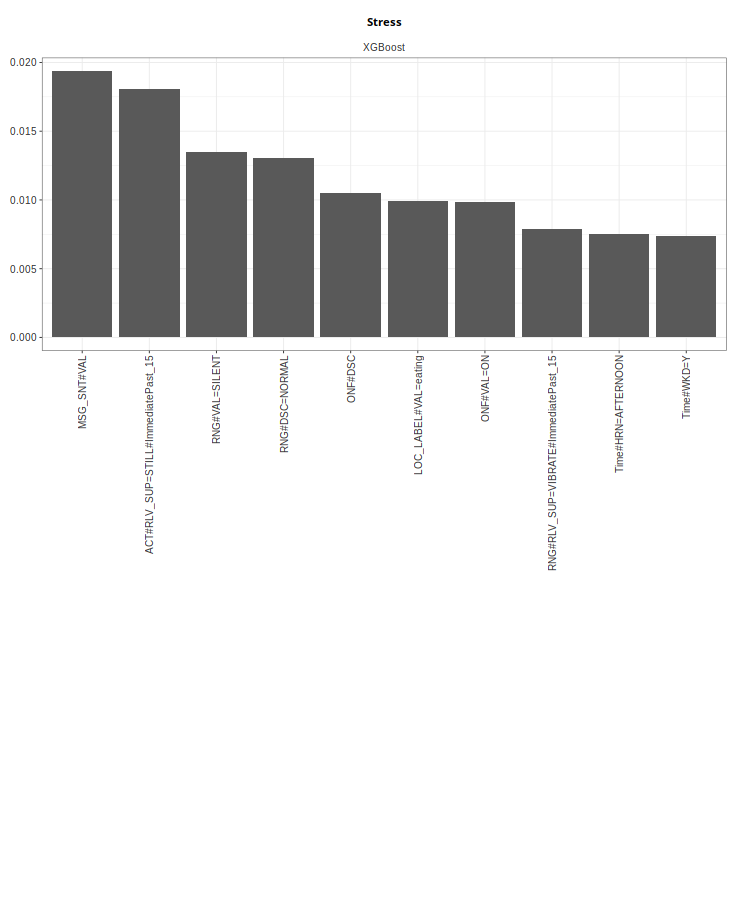

In [11]:
%%R -i IMPORTANCE_SUMMARY -w 26 -h 32 -u cm

plots <- list()

#for (l in c('valence', 'arousal', 'stress', 'disturbance')) {
for (l in c( 'stress')) {
    data <- IMPORTANCE_SUMMARY %>% filter(
        (label == l)
    )

    p_label <- ggplot() + geom_text(
        aes(x=.5, y=.5),
        label=str_to_title(l), 
        family='ssp', 
        fontface='bold',
        size=4
    ) + theme_void()

#     p_rf <- ggplot(
#         data %>% filter(alg == 'rf_os') %>% top_n(n=10, wt=importance),
#         aes(x=reorder(feature, -importance), y=importance),
#     ) + geom_col(
#     ) + THEME_DEFAULT + theme(
#         axis.text.x=element_text(angle=90, size=10, hjust=1, vjust=.5),
#         axis.title.x=element_blank(),
#         axis.title.y=element_blank()
#     ) + labs(
#         subtitle='Random Forest'
#     )
    
    p_xgb <- ggplot(
        data %>% filter(alg == 'xgb_os') %>% top_n(n=10, wt=importance),
        aes(x=reorder(feature, -importance), y=importance),
    ) + geom_col(
    ) + THEME_DEFAULT + theme(
        axis.text.x=element_text(angle=90, size=10, hjust=1, vjust=.5),
        axis.title.x=element_blank(),
        axis.title.y=element_blank()
    ) + labs(
        subtitle='XGBoost'
    )
    
    plots[[paste(l, 'label', sep='_')]] <- p_label
#     plots[[paste(l, 'rf', sep='_')]] <- p_rf
    plots[[paste(l, 'xgb', sep='_')]] <- p_xgb
}

#p <- plots$arousal_label + plots$valence_label
#p <- p / (plots$arousal_rf | plots$arousal_xgb | plots$valence_rf | plots$valence_xgb)
#p <- p / (plots$stress_label + plots$disturbance_label)
#p <- p / (plots$stress_rf | plots$stress_xgb | plots$disturbance_rf | plots$disturbance_xgb)
p <- plots$stress_label 
# p <- p / (plots$stress_rf | plots$stress_xgb)
p <- p / (plots$stress_xgb)

p <- p + plot_layout(
    heights=c(1.1, 10, 1.1, 10)
)

ggsave(paste('./fig/imp.pdf'), plot=p, width=26, height=32, unit='cm', device=cairo_pdf)
print(p)


# Feature Importances (Shap)

In [12]:
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import shap

def feature_importance_shap(estimator, X):
    explainer = None
    # Check if the estimator is an instance of RandomForest
    if isinstance(estimator, RandomForestClassifier):
        explainer = shap.Explainer(estimator)
    elif isinstance(estimator, DummyClassifier):
        return None
    elif isinstance(estimator.model, XGBClassifier):
        # Pass the inner model to the explainer
        explainer = shap.Explainer(estimator.model)
    else:
        print("Estimator not supported:", type(estimator))
        return None

    shap_values = explainer.shap_values(X)
    if isinstance(shap_values, list): # Handling for binary classification in RandomForest
        shap_values = shap_values[1]
    names = X.columns if hasattr(estimator, 'feature_names_in_') else None # get feature names from the model itself
    return names, np.abs(shap_values).mean(axis=0)

In [13]:
import os
import pandas as pd
from collections import defaultdict
import ray

with on_ray():
    IMPORTANCE_EVAL = defaultdict(list)
    DIR_EVAL = os.path.join(PATH_INTERMEDIATE, 'eval')

    @ray.remote
    def process_file(file_path, dir_l):
        res = load(os.path.join(dir_l, file_path))

        f_norm = file_path[:file_path.index('.pkl')]
        fold = f_norm[f_norm.rindex('#')+1:]
        alg = f_norm[:file_path.rindex('#')]

        feat_imp = feature_importance_shap(res.estimator, res.X_test)
        if not feat_imp:
            return None

        names, importance = feat_imp
        new_names = []
        for n in names:
            for c in res.categories:
                n = n.replace(f'{c}_', f'{c}=')
            new_names.append(n)

        d = pd.DataFrame(
            importance.reshape(1, -1),
            columns=new_names
        )
        return (l, fold, alg, d)


    file_tasks = []
    for l in ['stress']:
        dir_l = os.path.join(DIR_EVAL, l)
        if not os.path.exists(dir_l):
            continue

        for f in os.listdir(dir_l):
            if f != '.ipynb_checkpoints':
                file_tasks.append(process_file.remote(f, dir_l))

    IMPORTANCE_SUMMARY = []
    results = ray.get(file_tasks)
    for result in results:
        if result is not None:
            l, fold, alg, d = result
            IMPORTANCE_EVAL[(l, fold, alg)].append(d)

    for (l, fold, alg), v in IMPORTANCE_EVAL.items():
        new_v = pd.concat(
            v, axis=0
        ).fillna(0.0).mean().reset_index().set_axis(
            ['feature', 'importance'], axis=1
        ).assign(
            label=l,
            fold=fold,
            alg=alg
        )
        IMPORTANCE_SUMMARY.append(new_v)

    IMPORTANCE_SUMMARY = pd.concat(IMPORTANCE_SUMMARY, axis=0, ignore_index=True)


2024-04-30 22:05:47,313	INFO worker.py:1431 -- Connecting to existing Ray cluster at address: 143.248.57.77:6379...
2024-04-30 22:05:47,318	INFO worker.py:1612 -- Connected to Ray cluster. View the dashboard at 127.0.0.1:8265 


In [14]:
IMPORTANCE_SUMMARY_xgb_os = IMPORTANCE_SUMMARY[IMPORTANCE_SUMMARY['alg'] =='xgb_os']

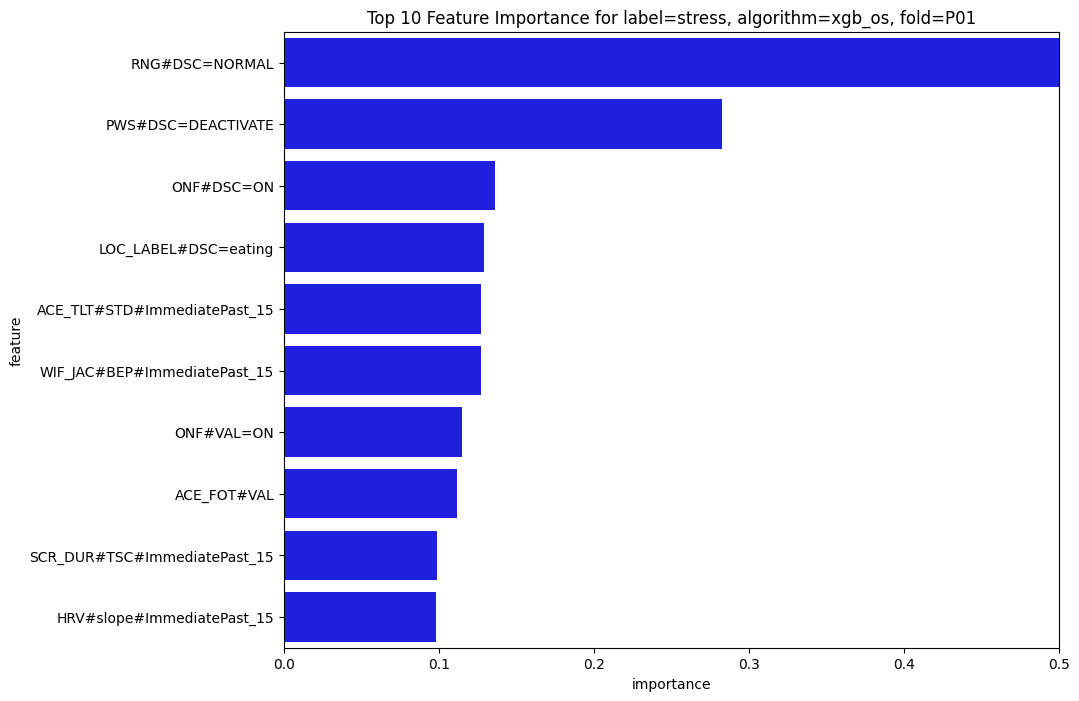

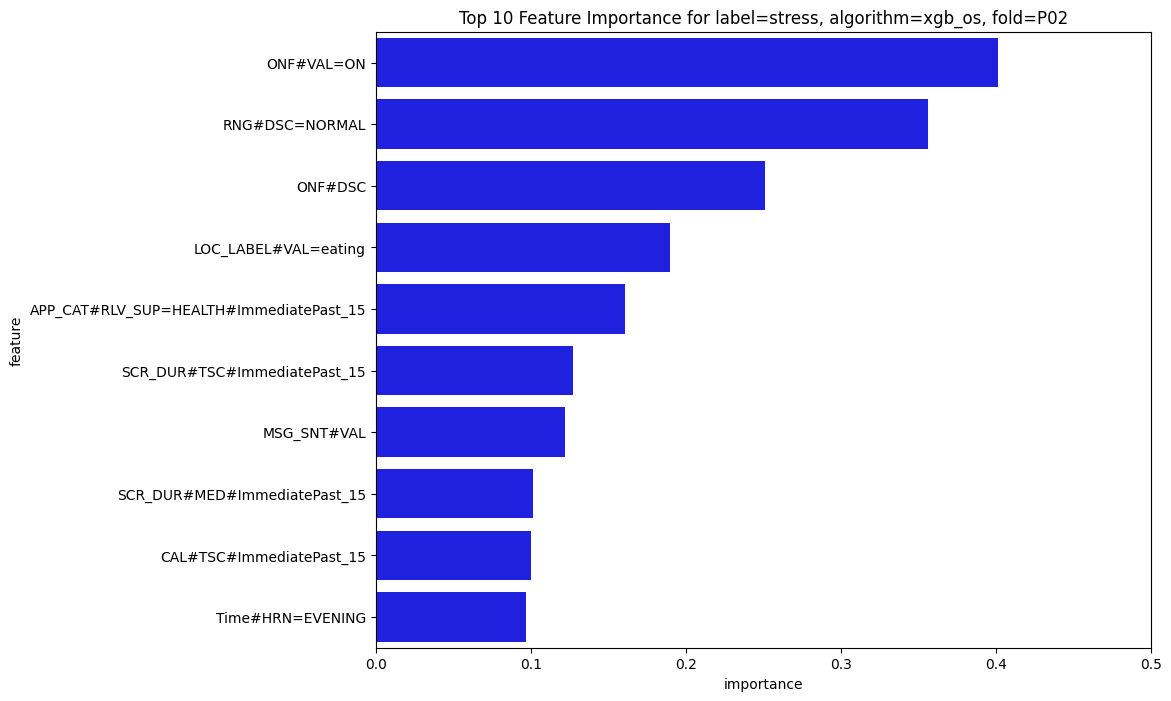

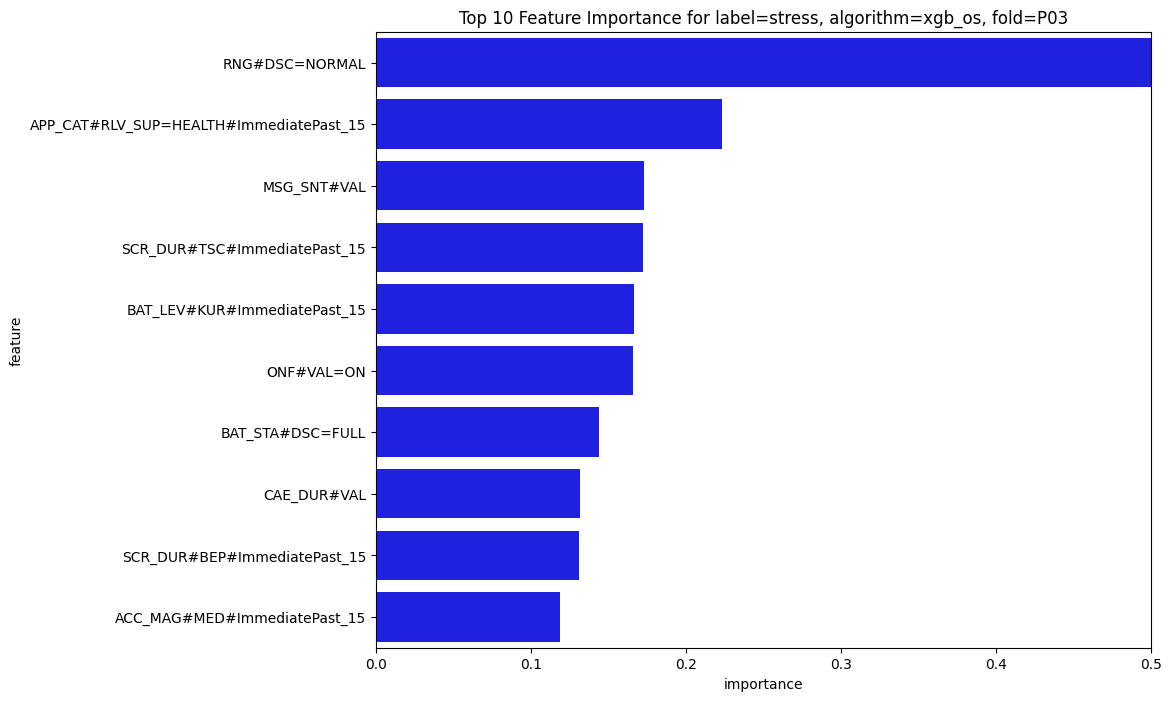

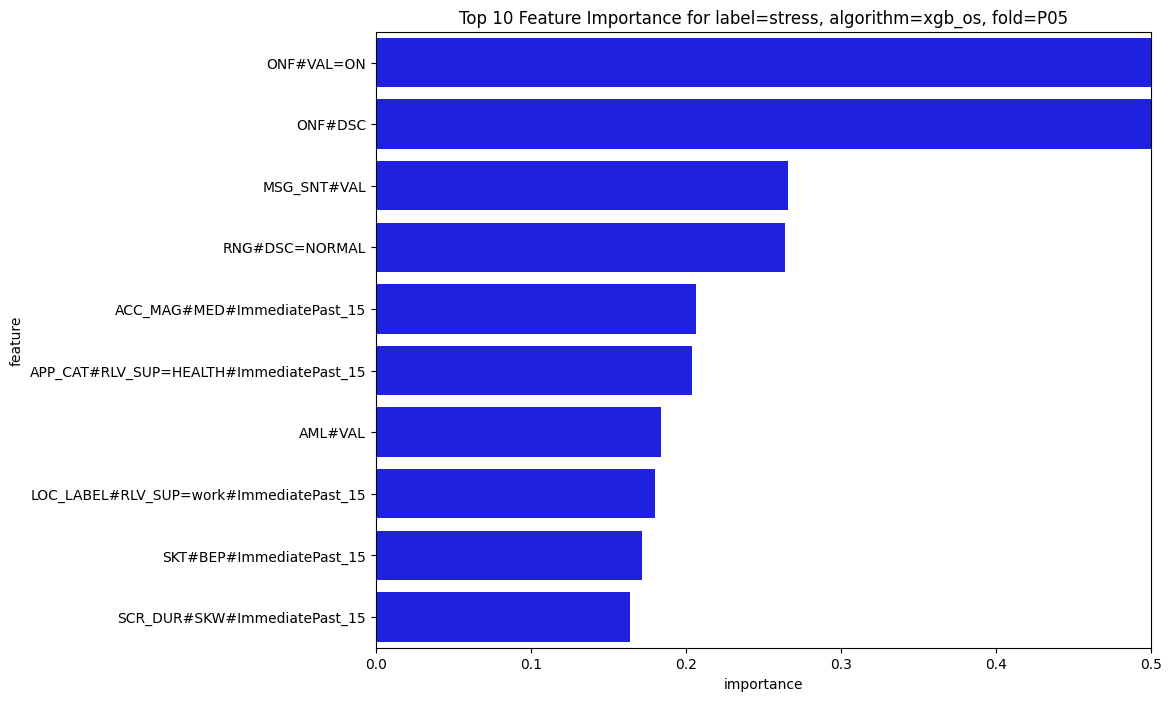

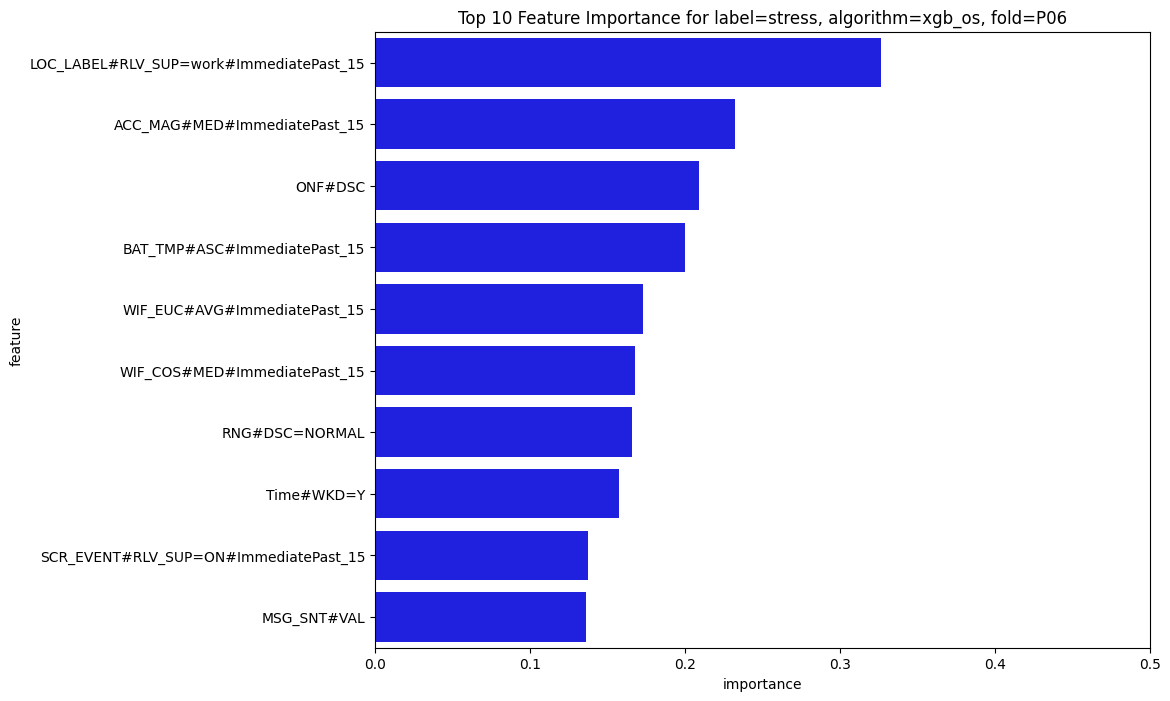

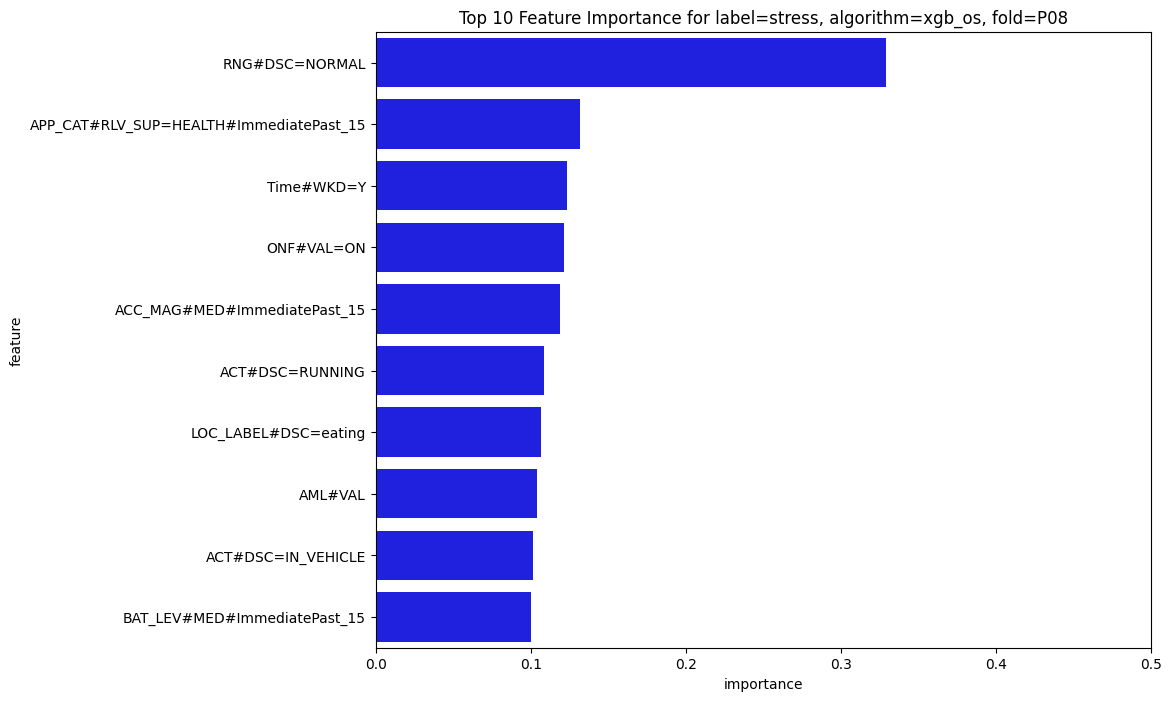

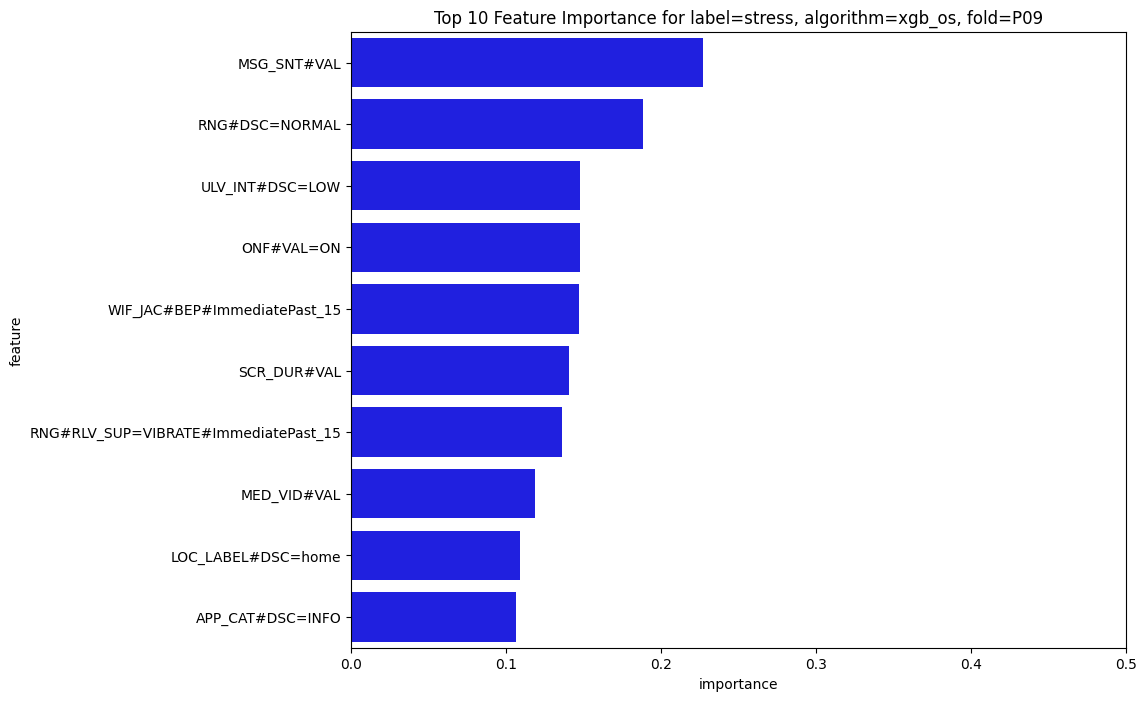

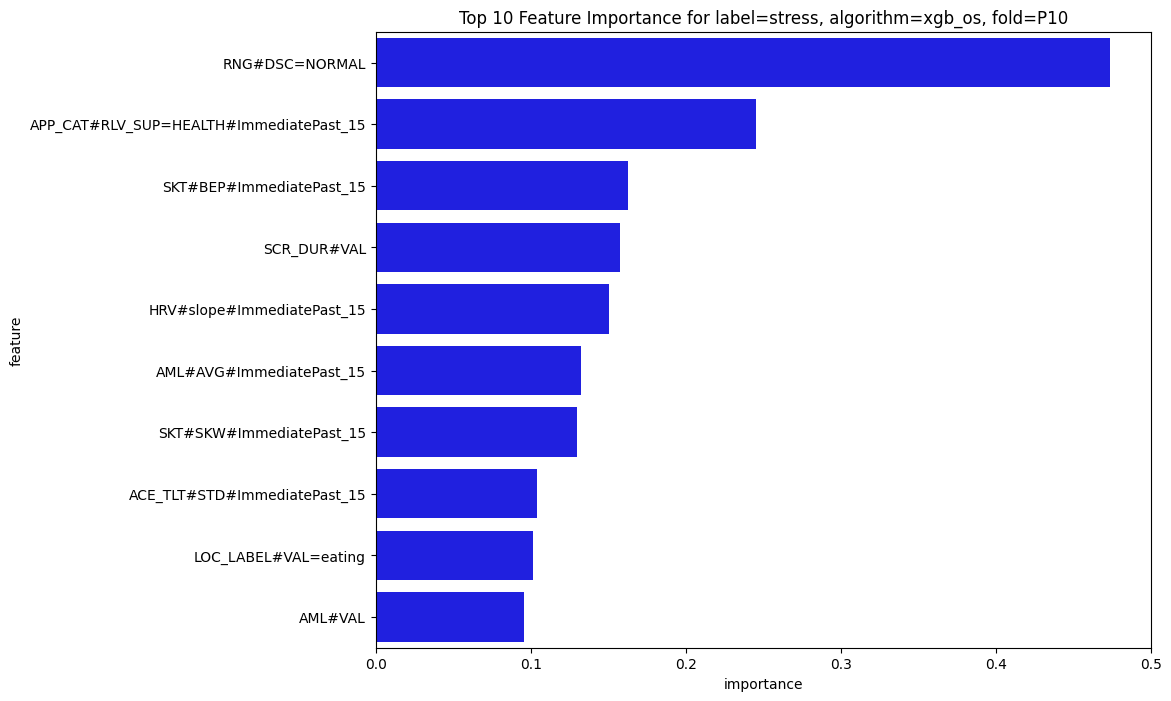

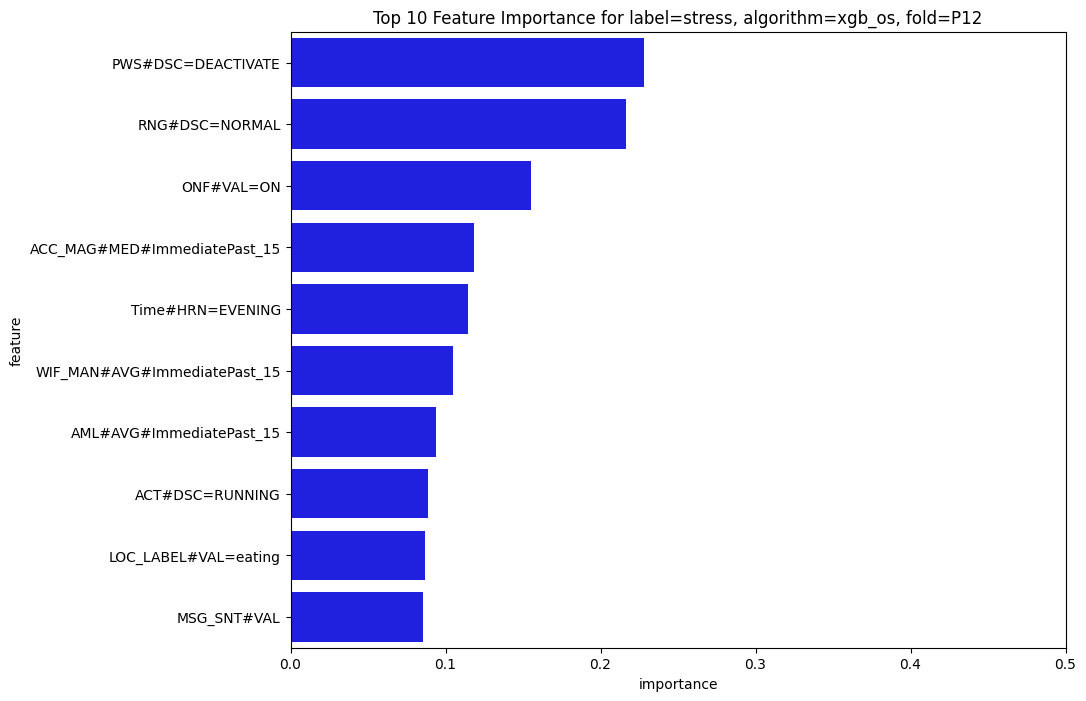

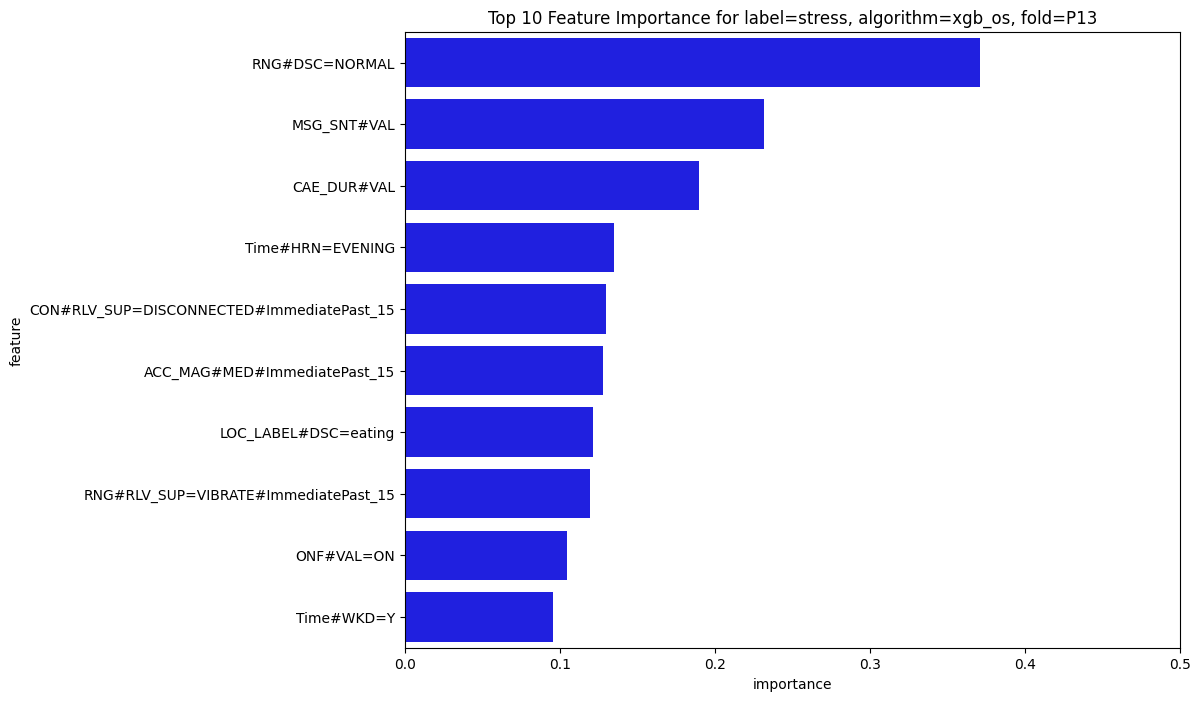

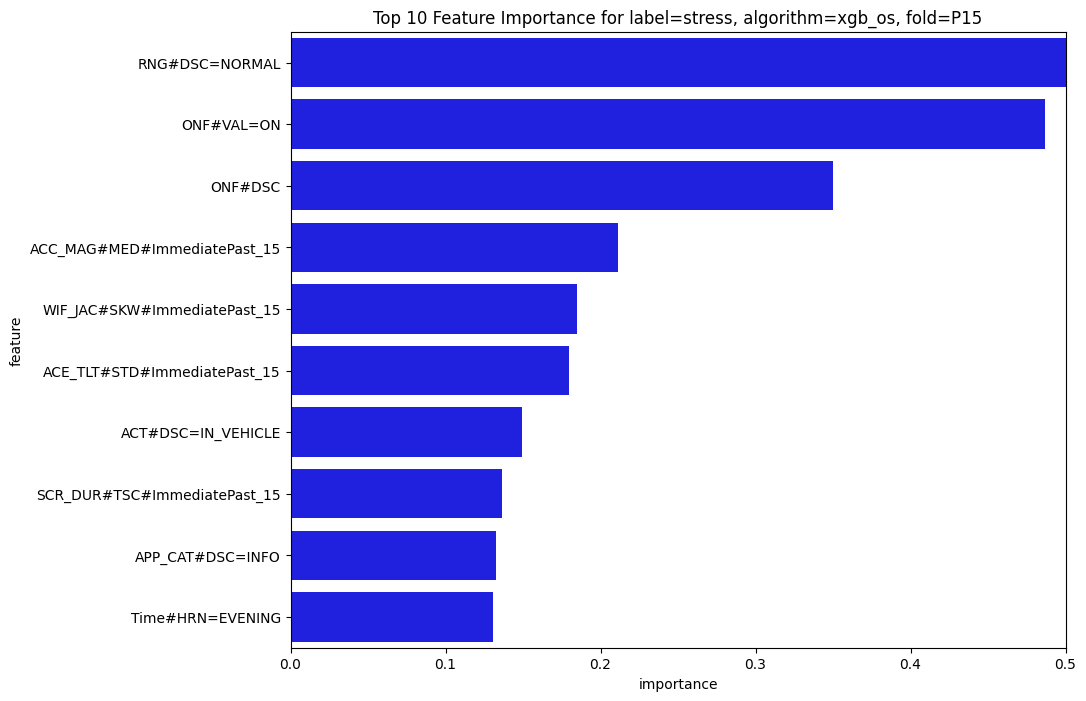

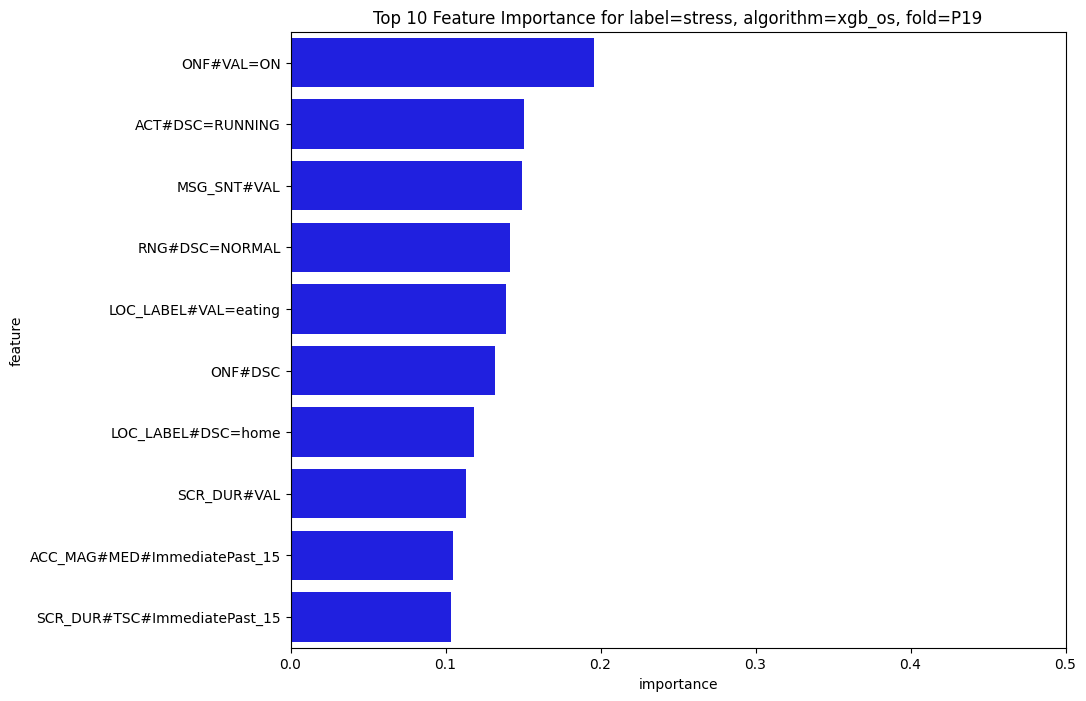

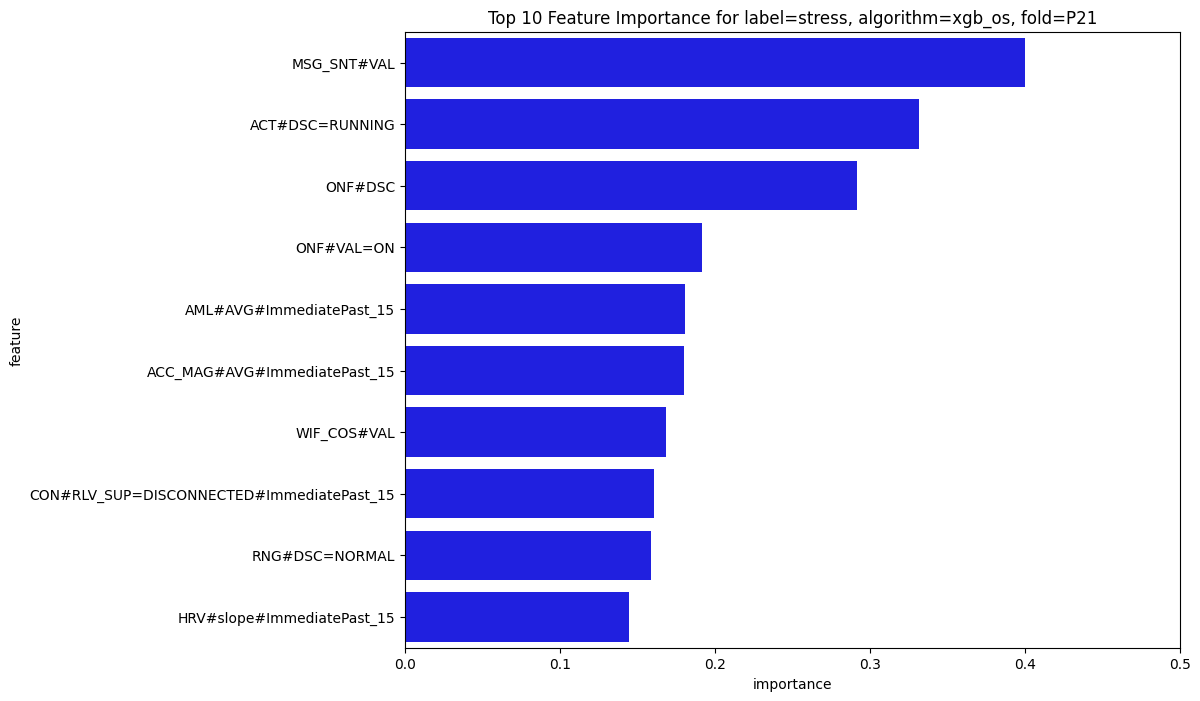

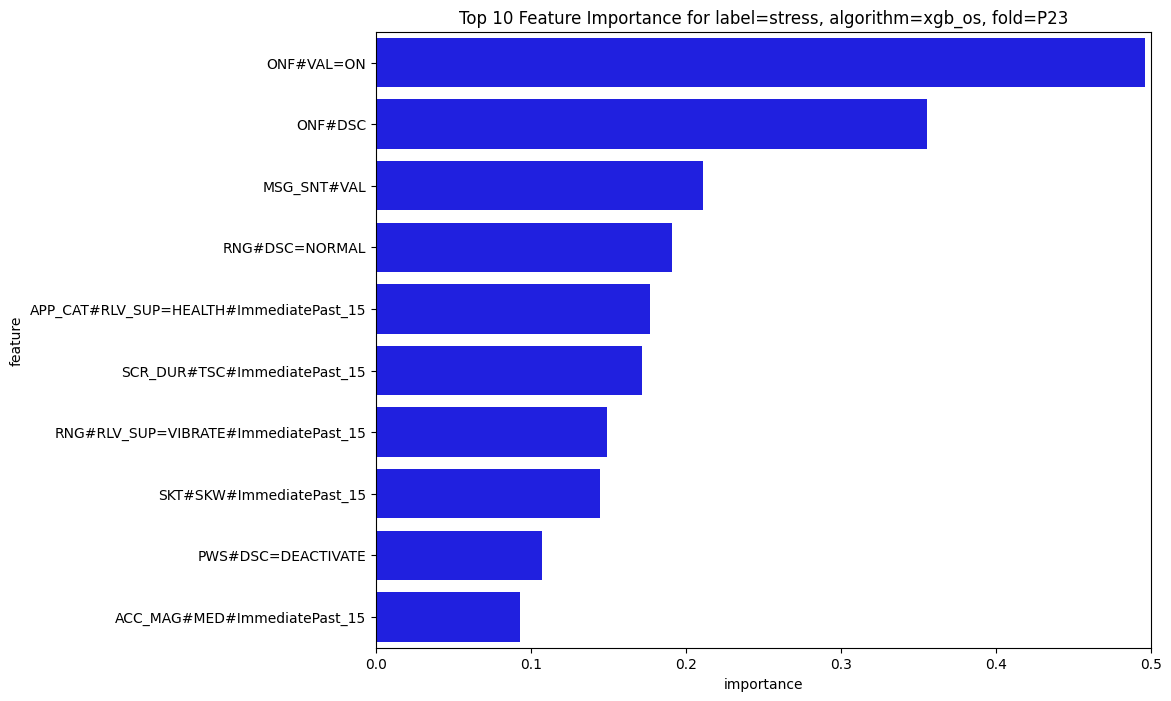

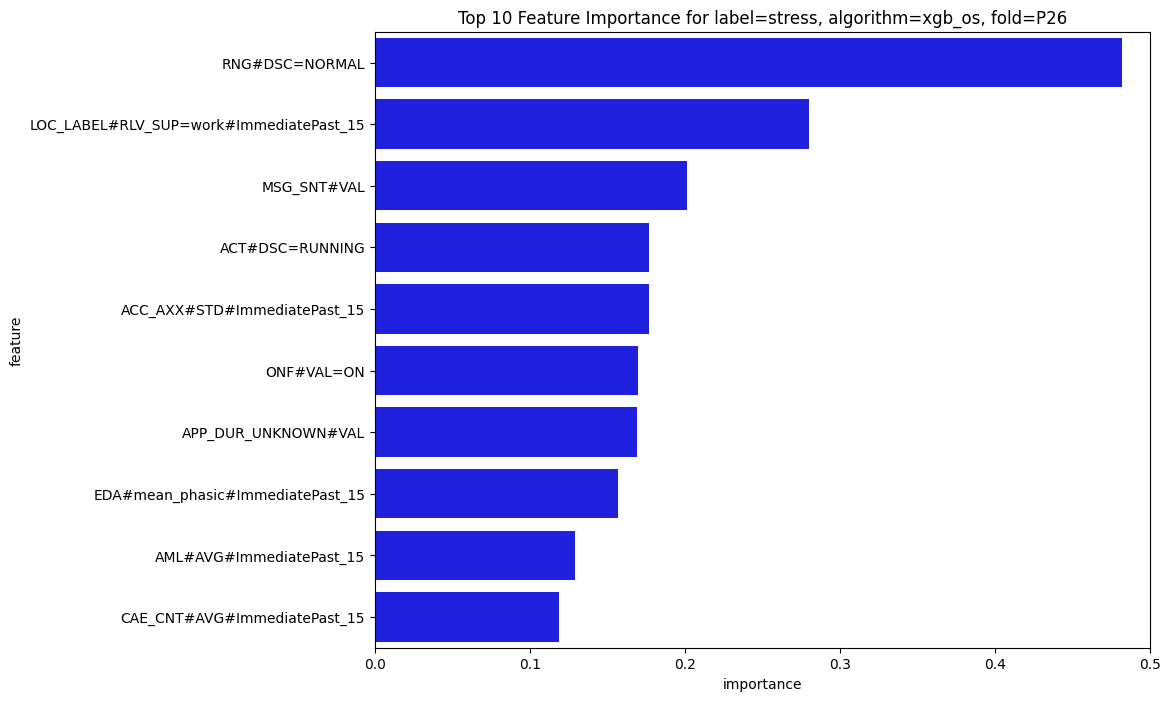

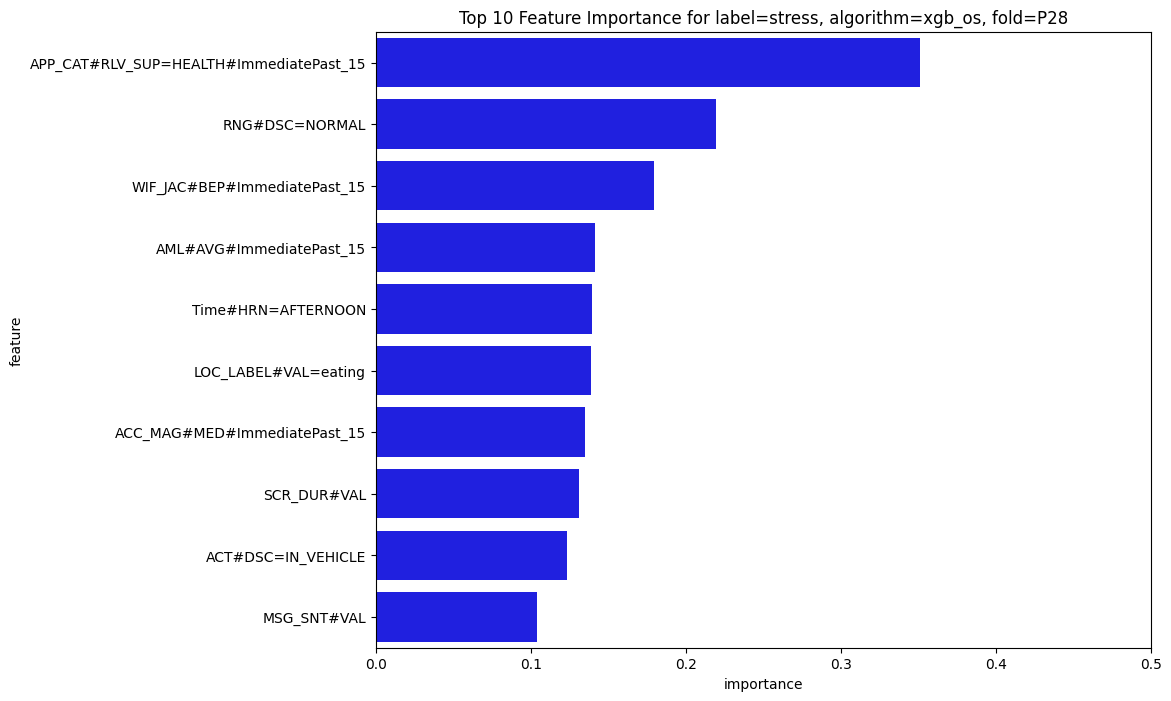

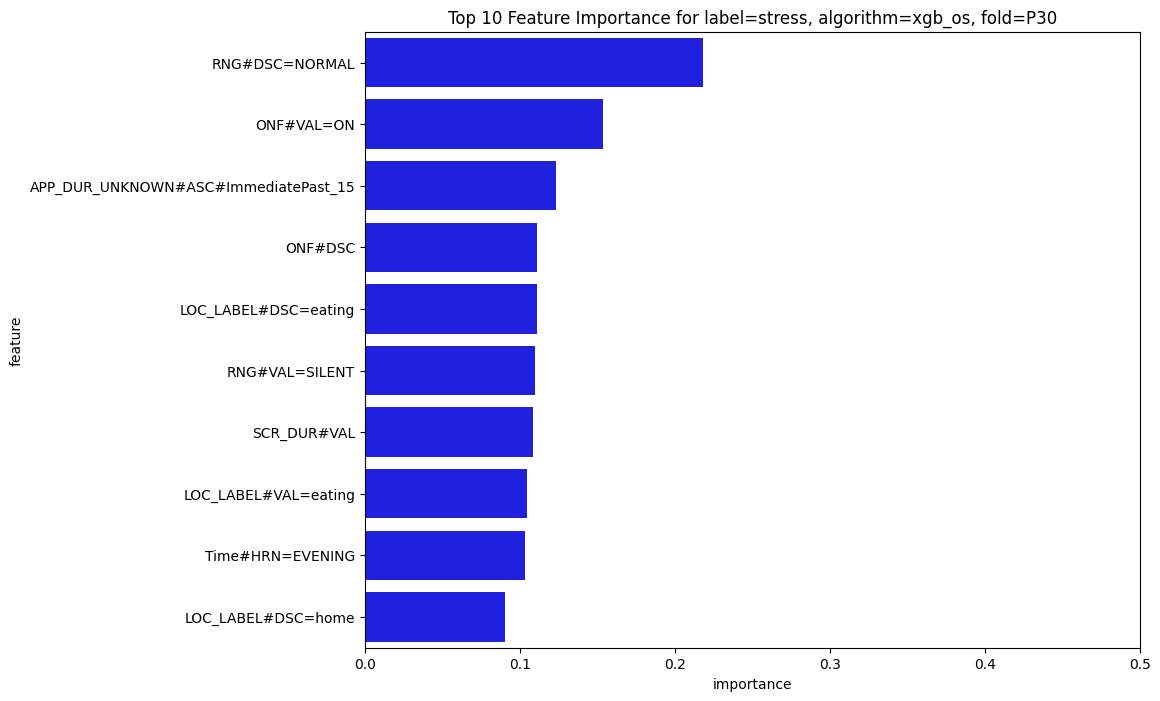

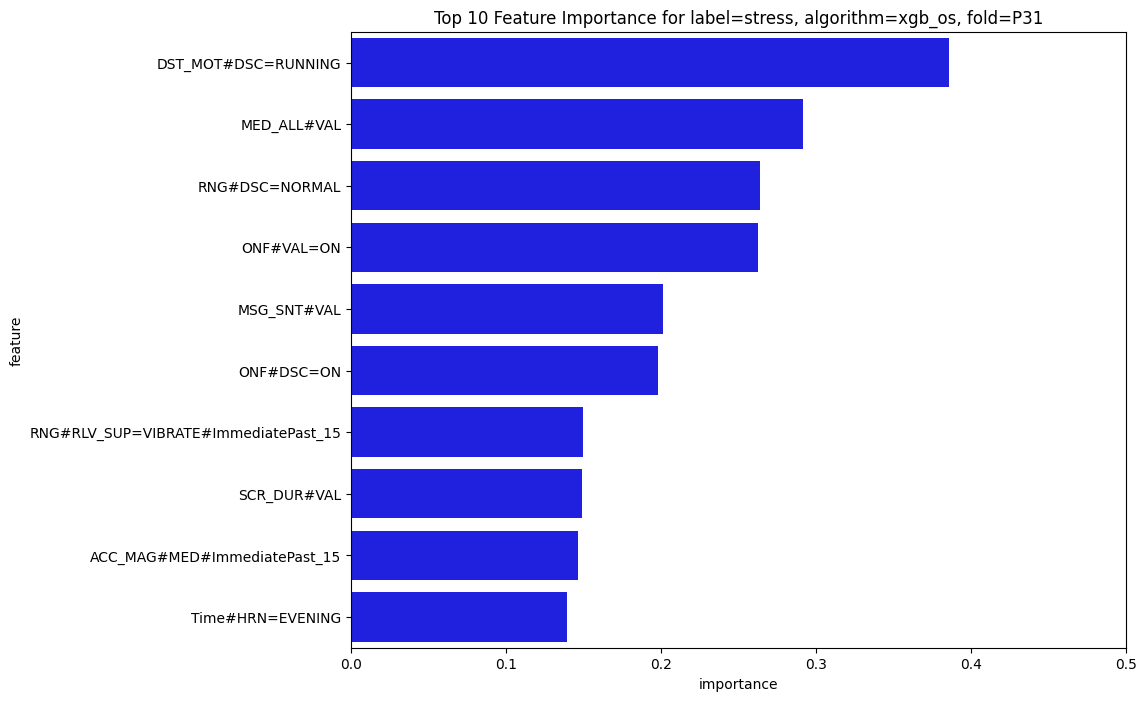

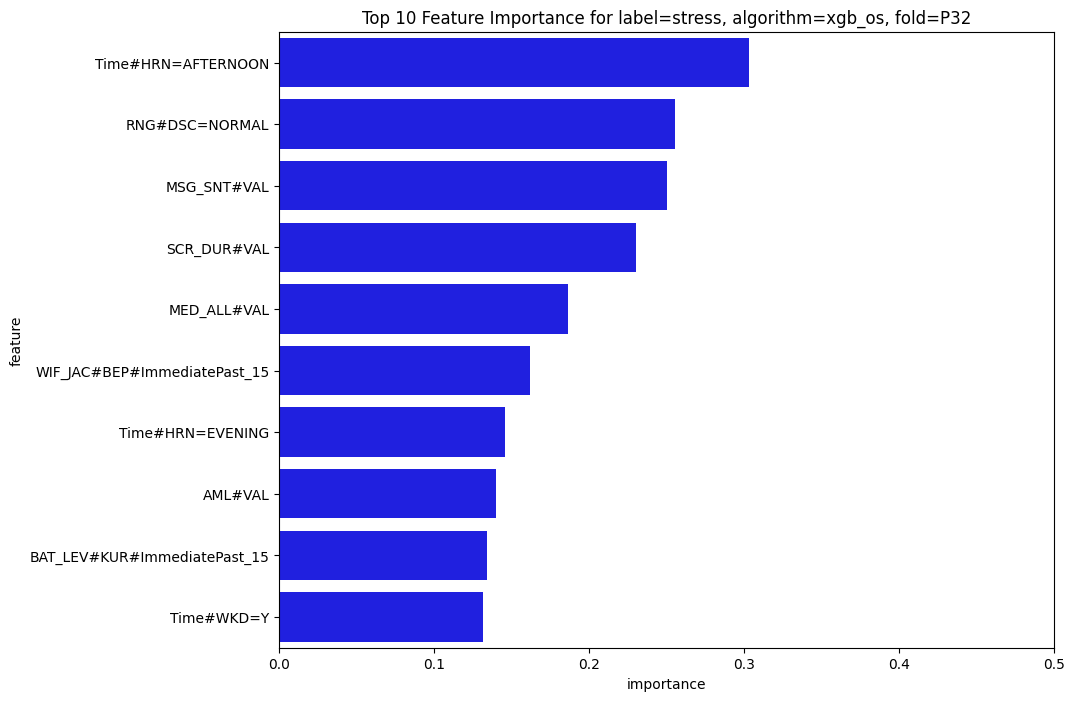

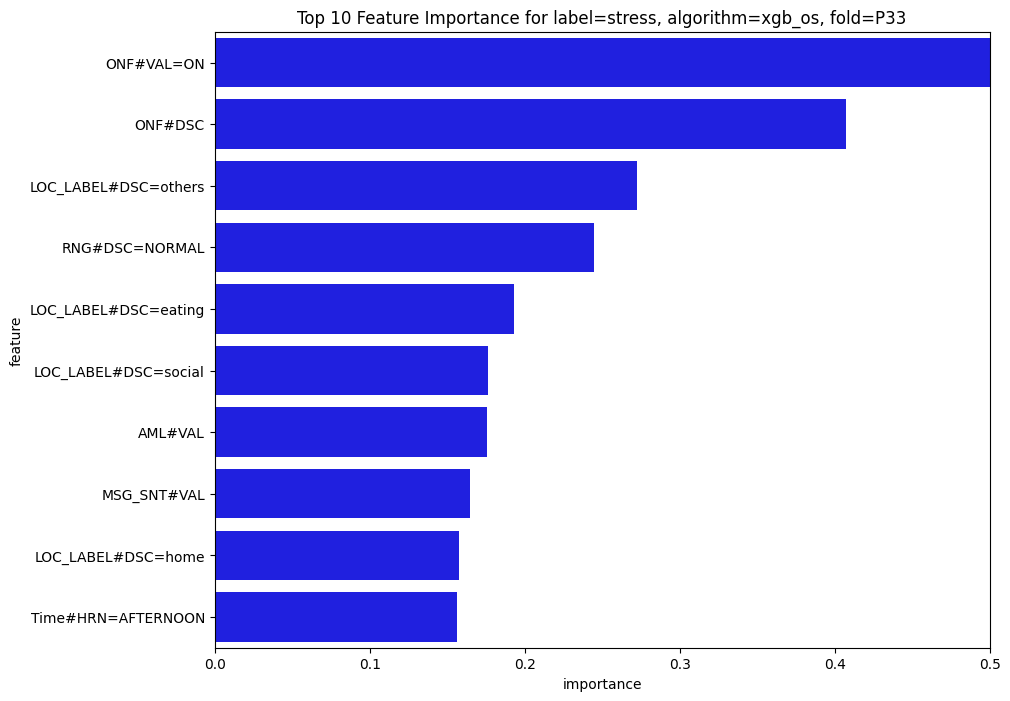

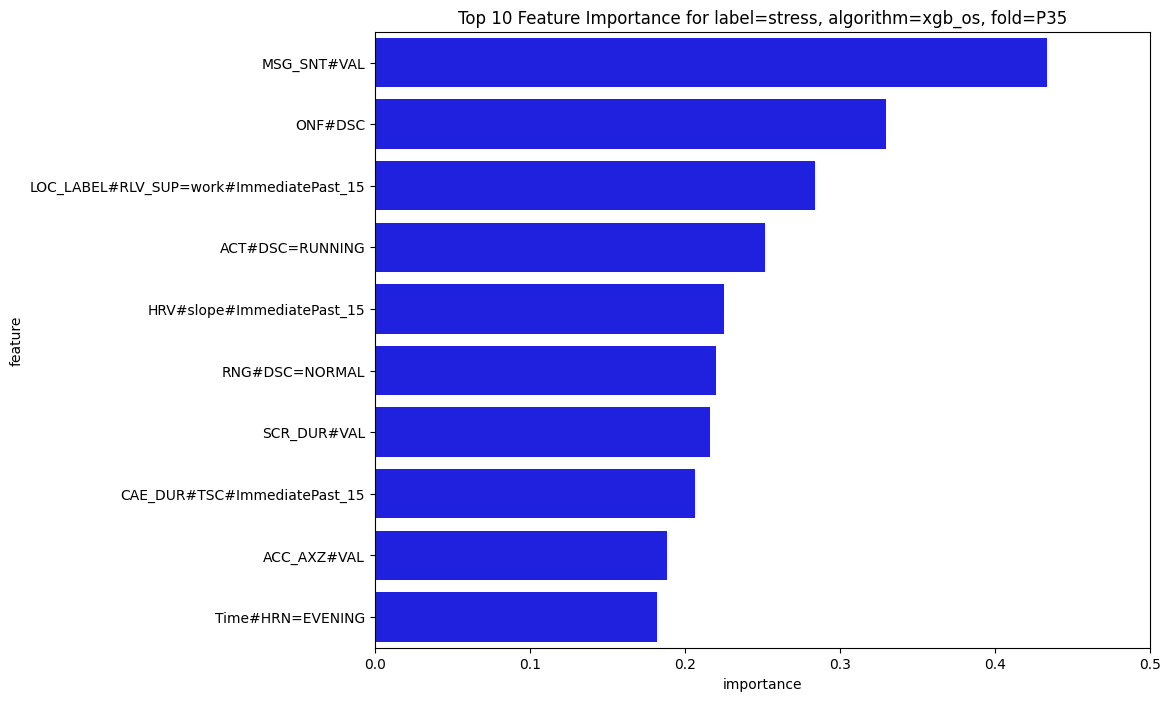

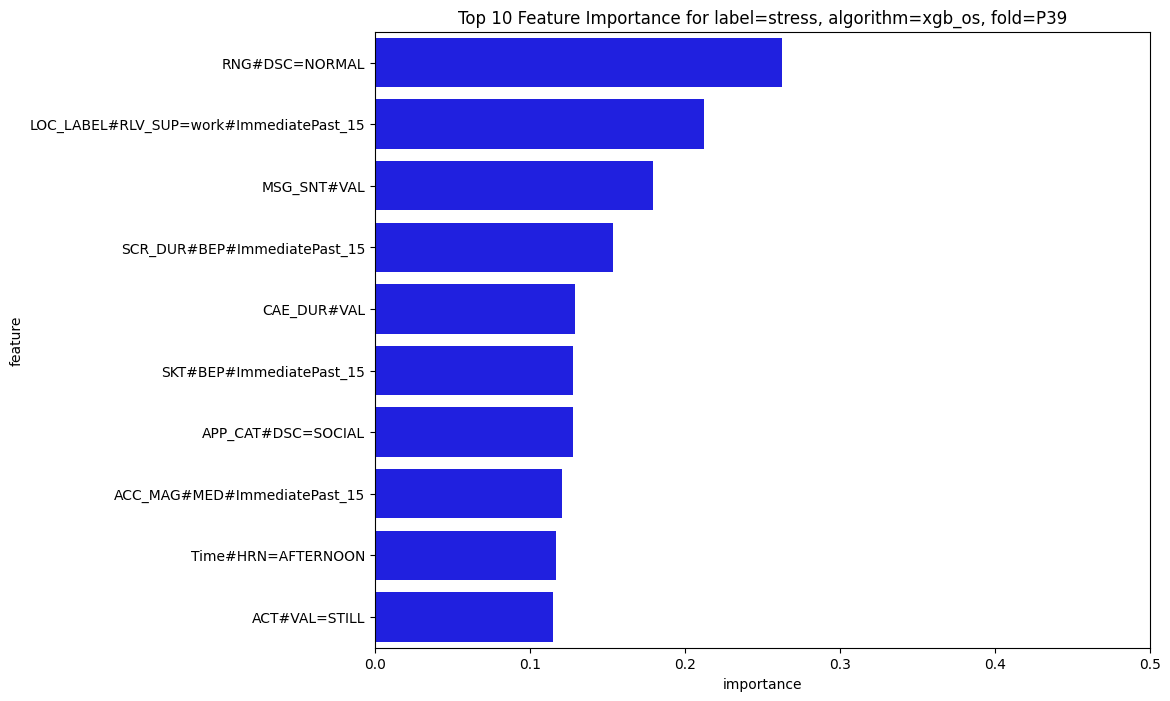

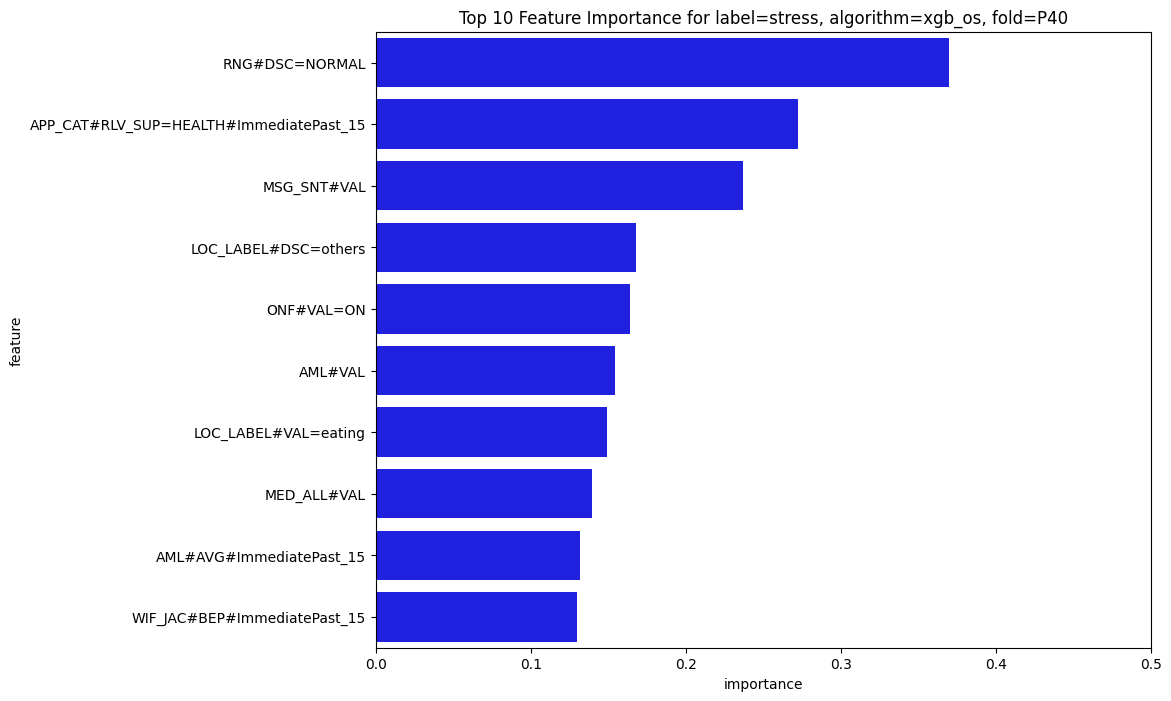

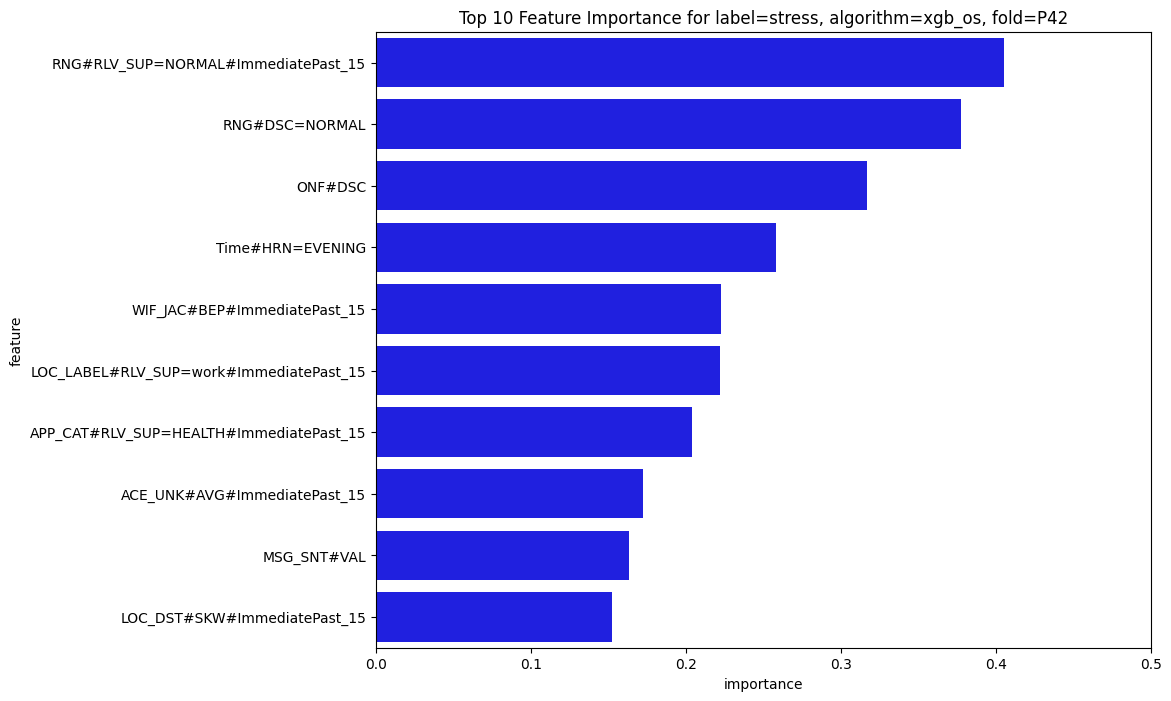

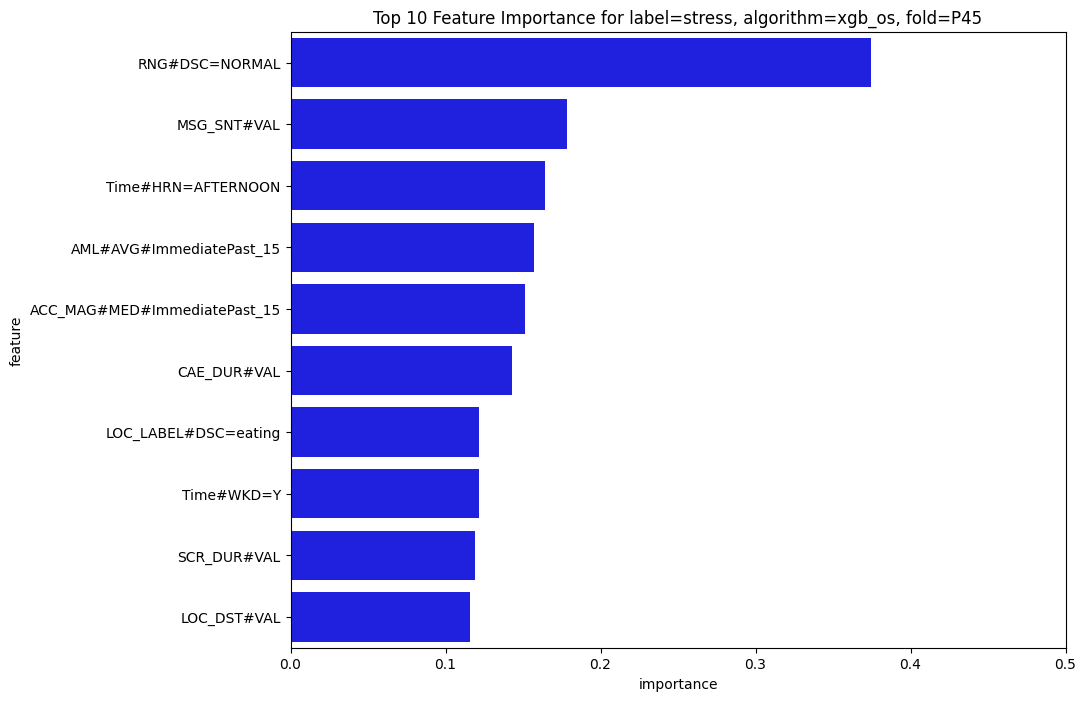

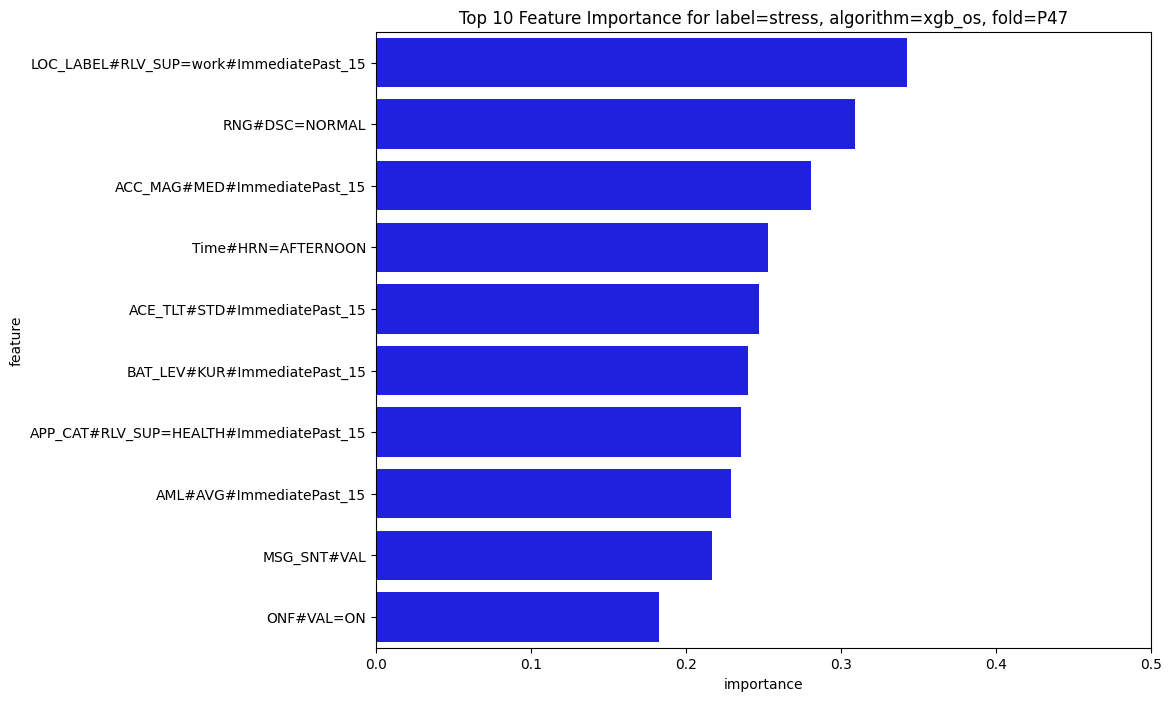

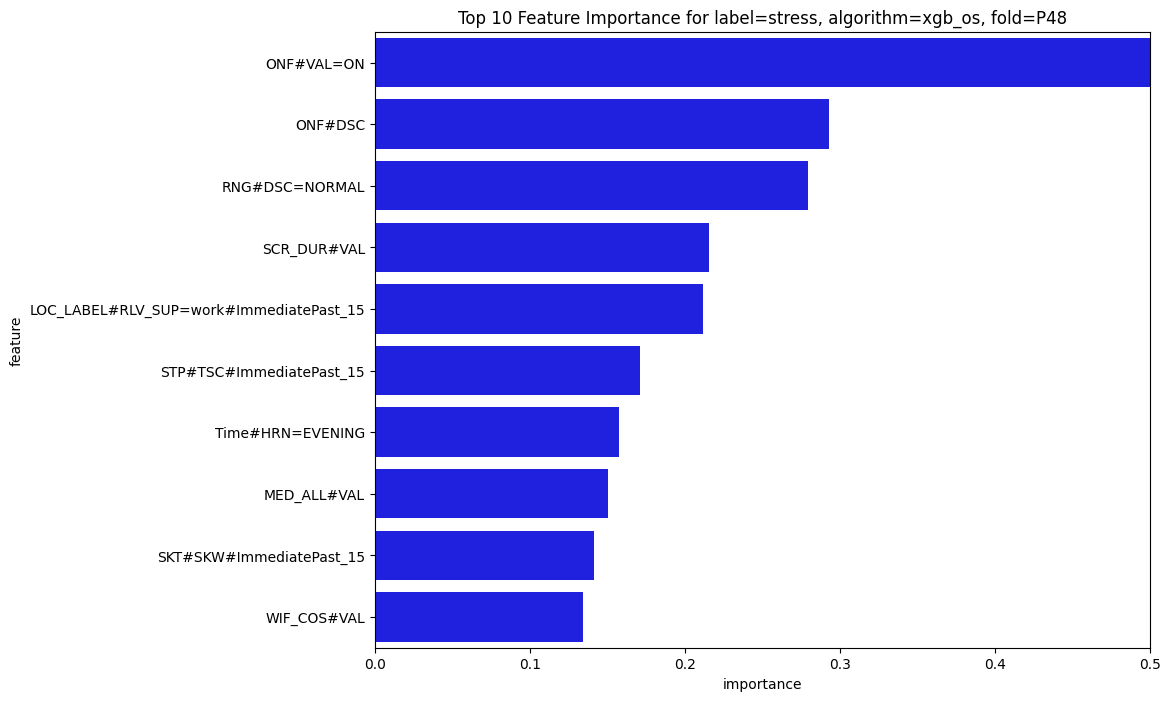

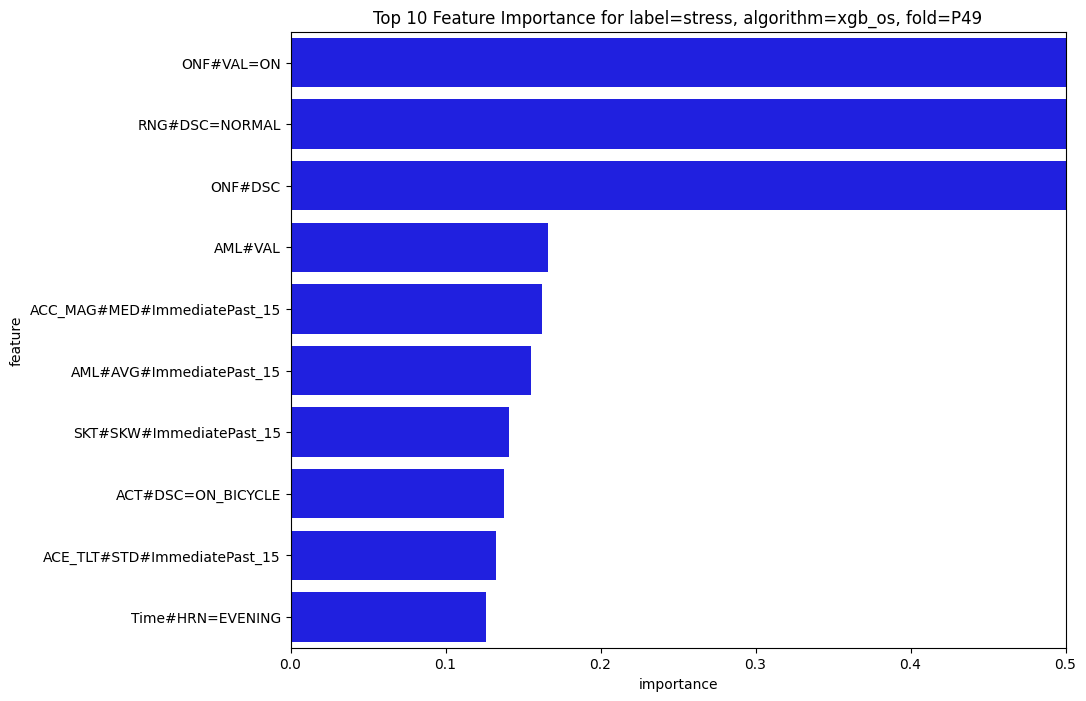

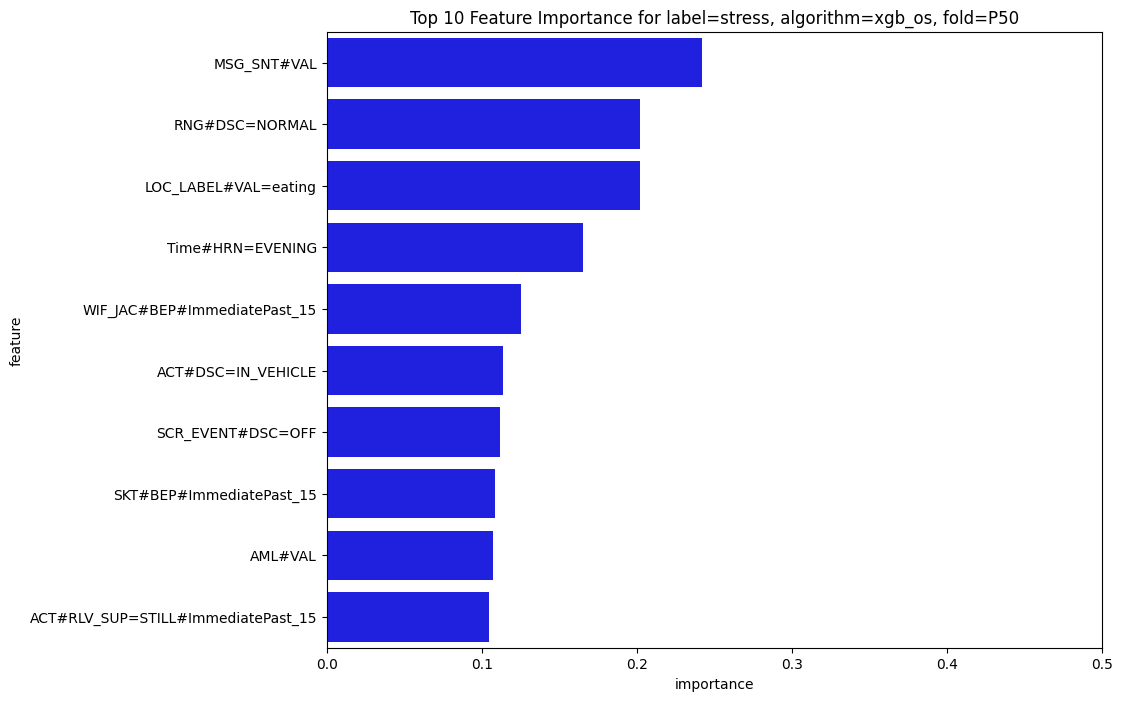

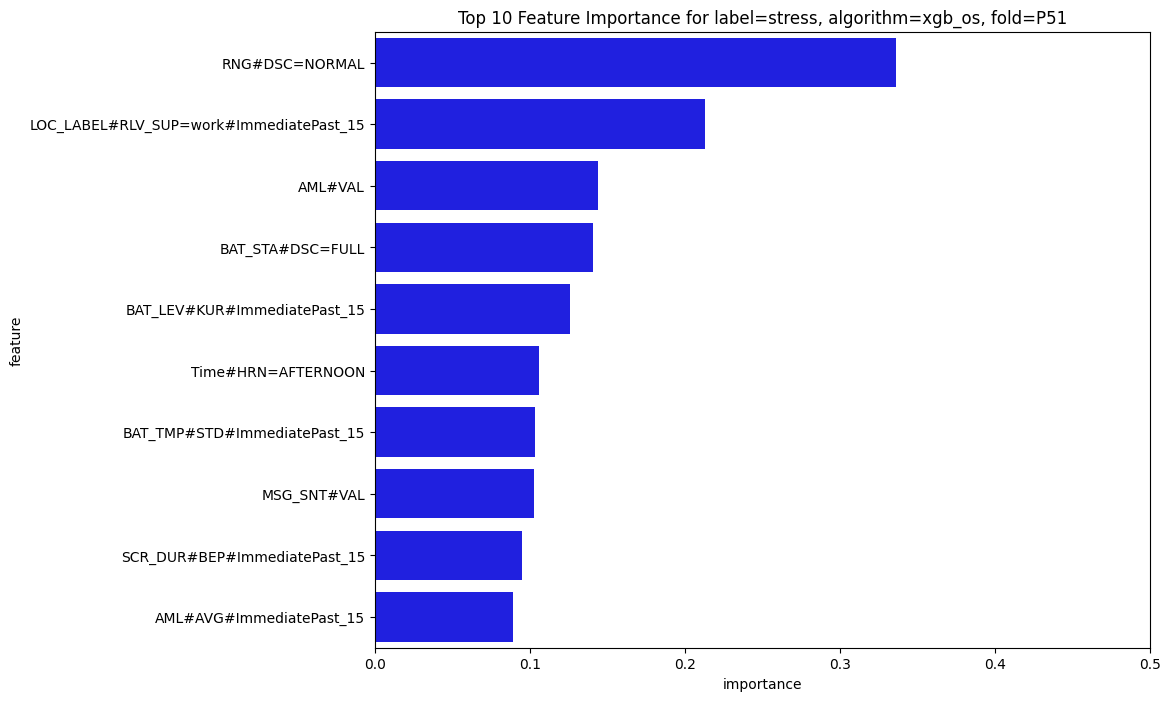

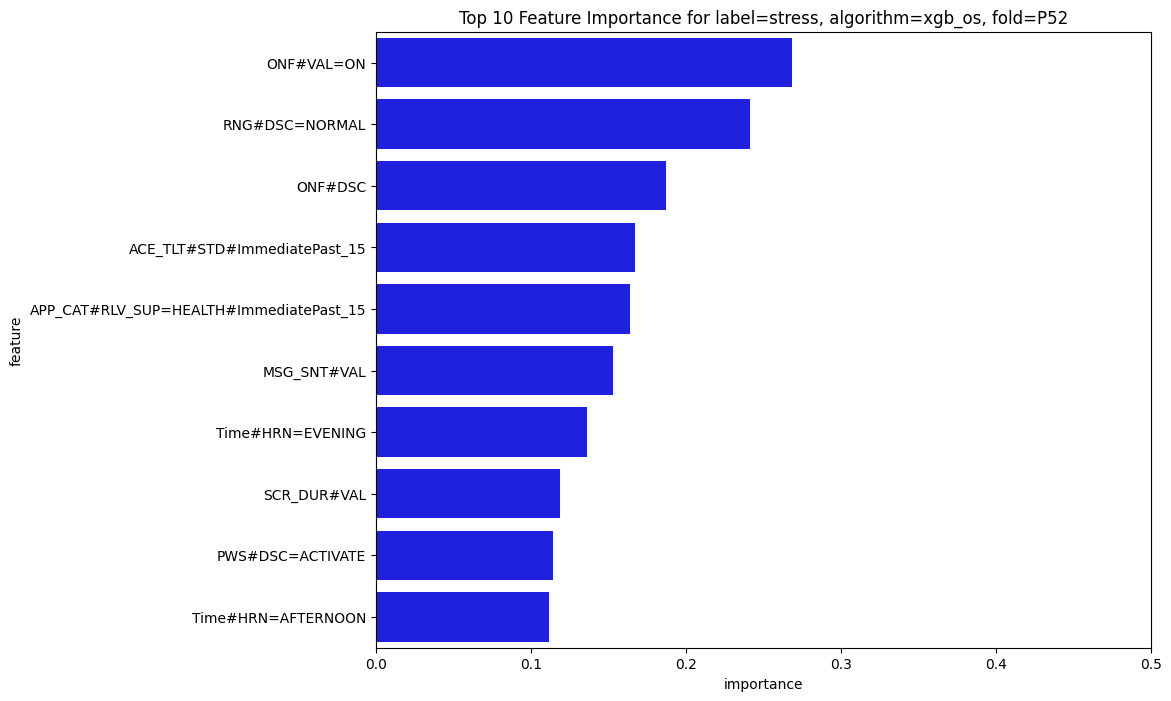

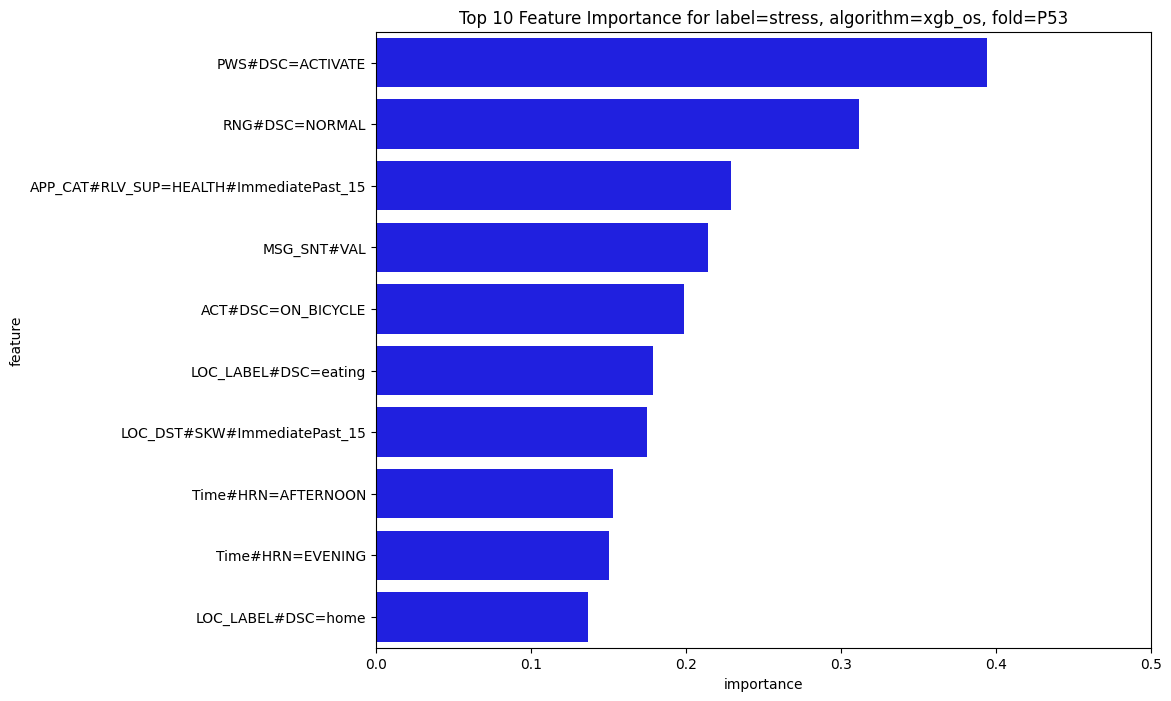

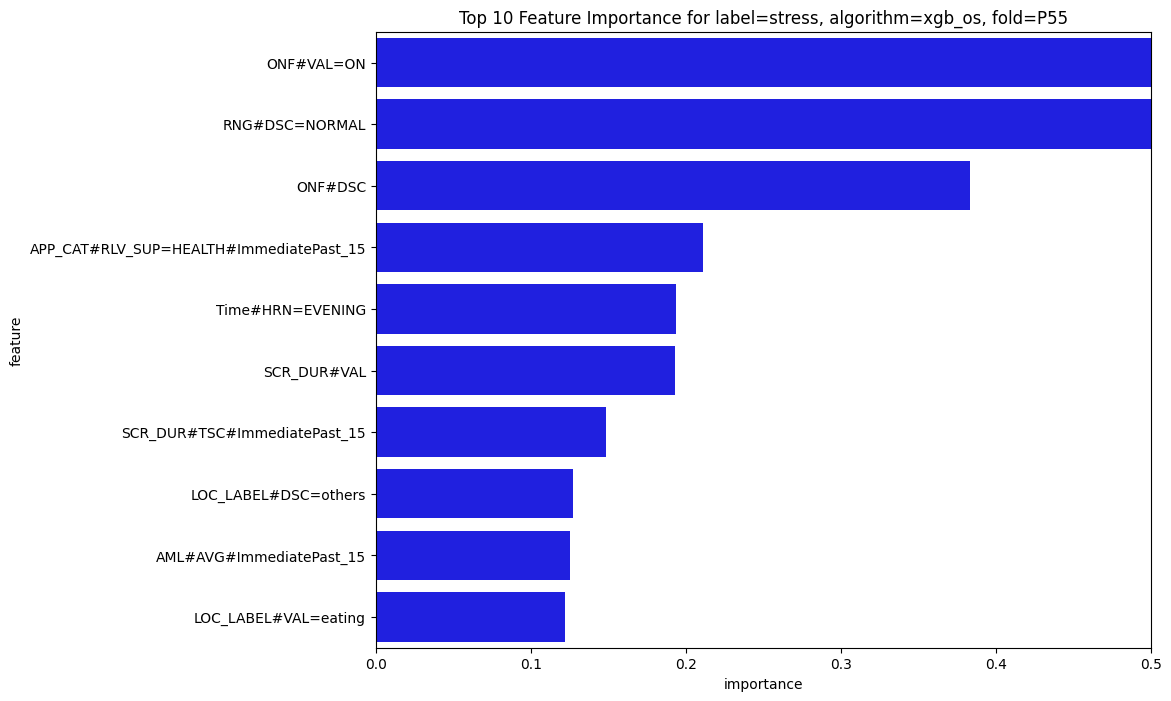

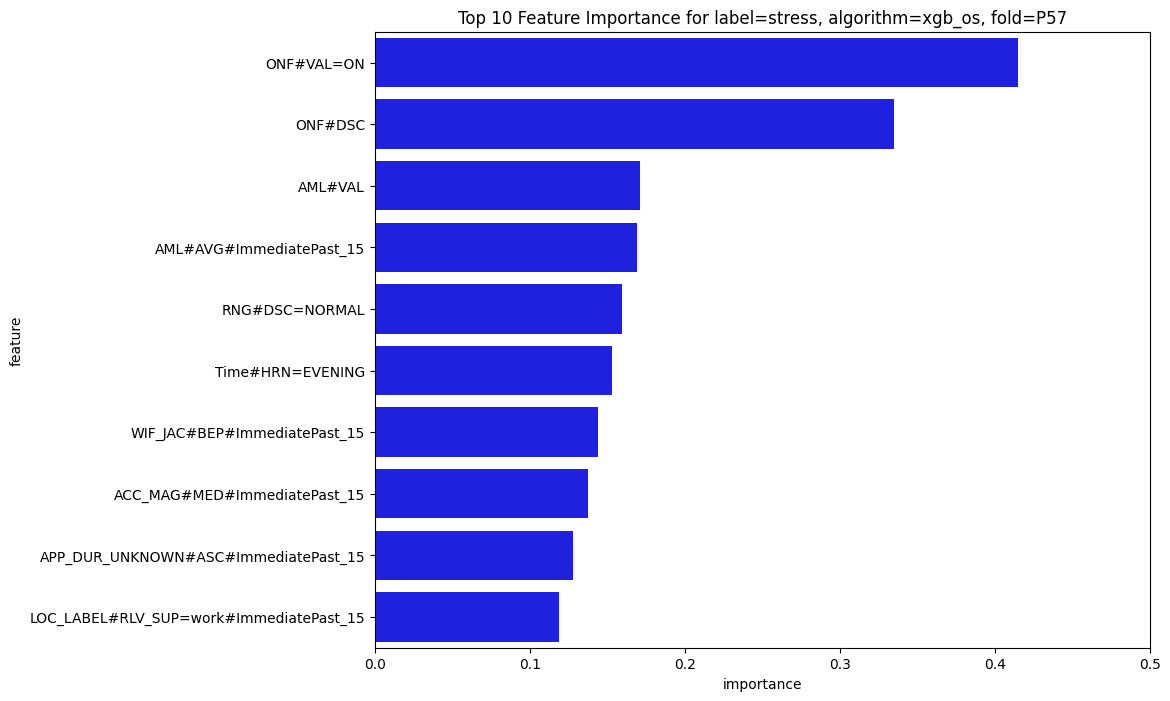

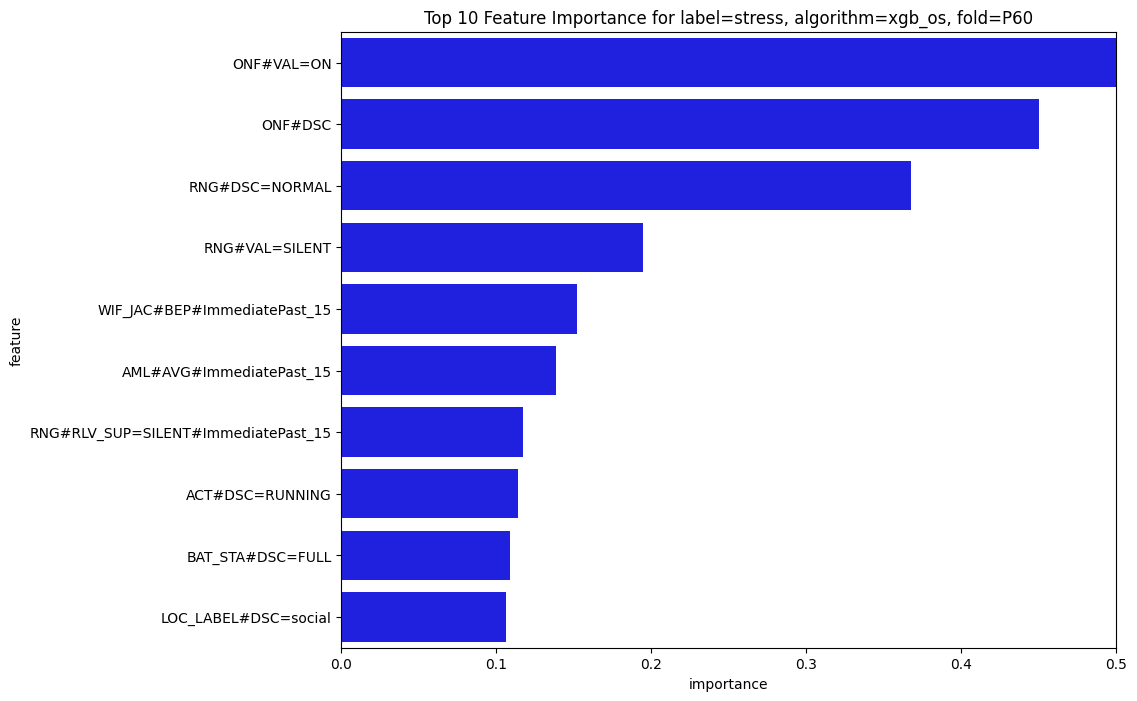

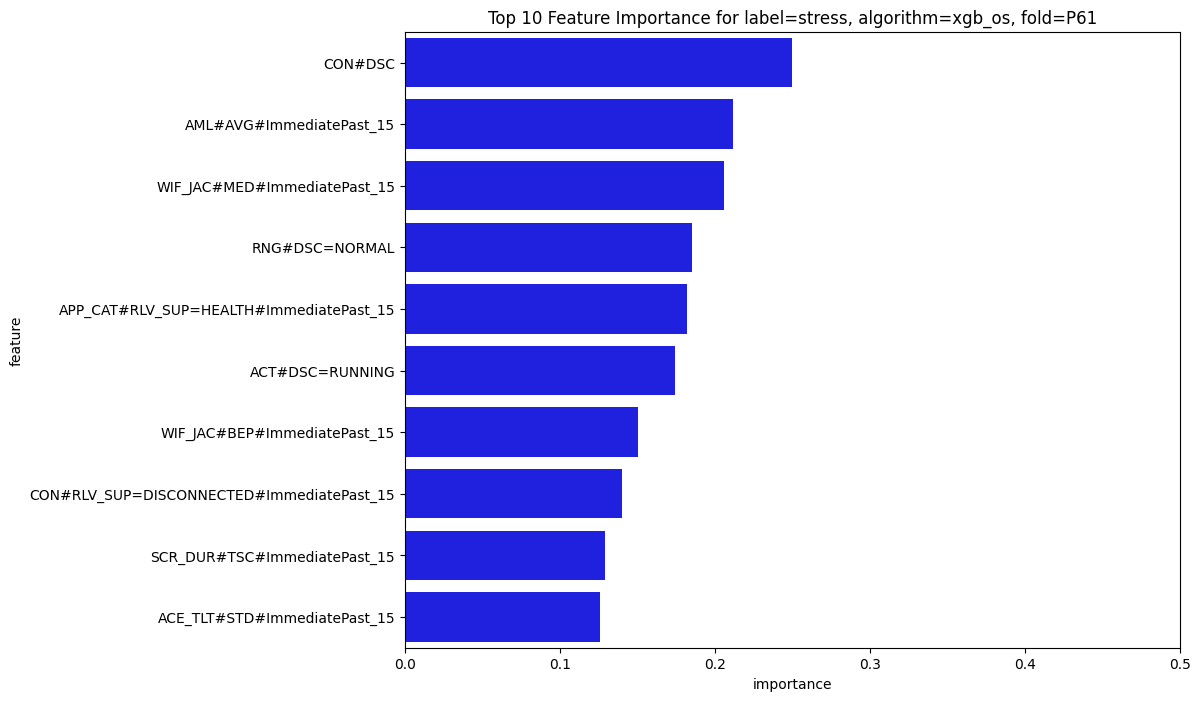

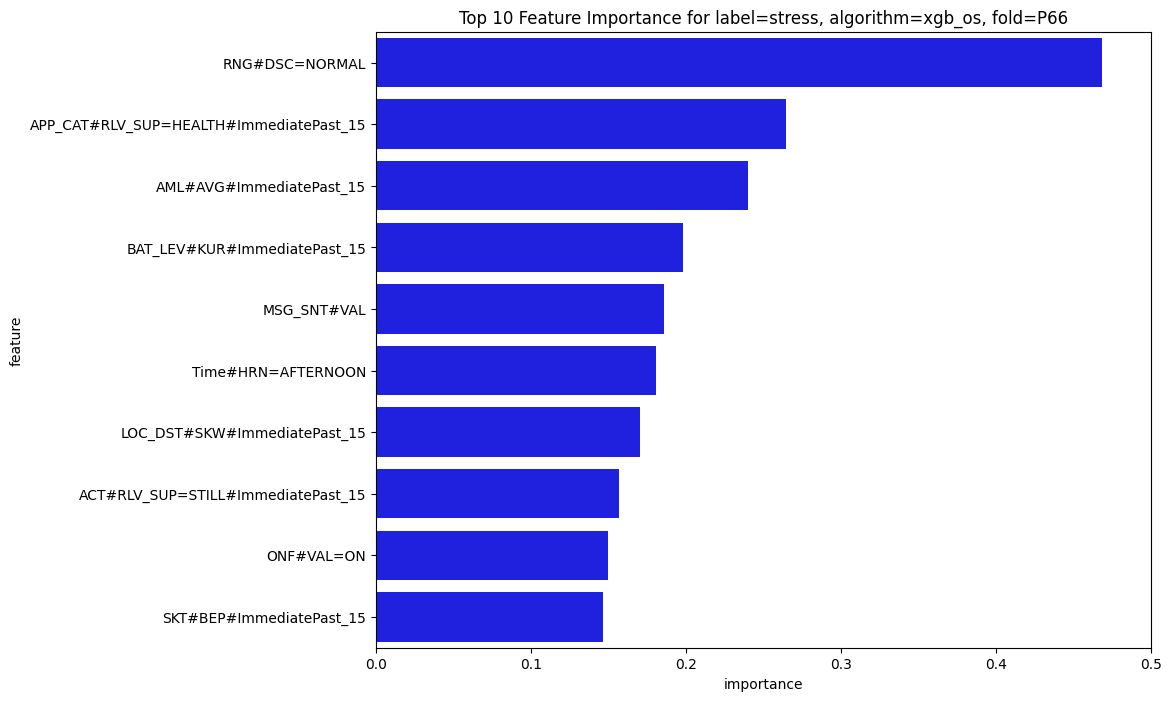

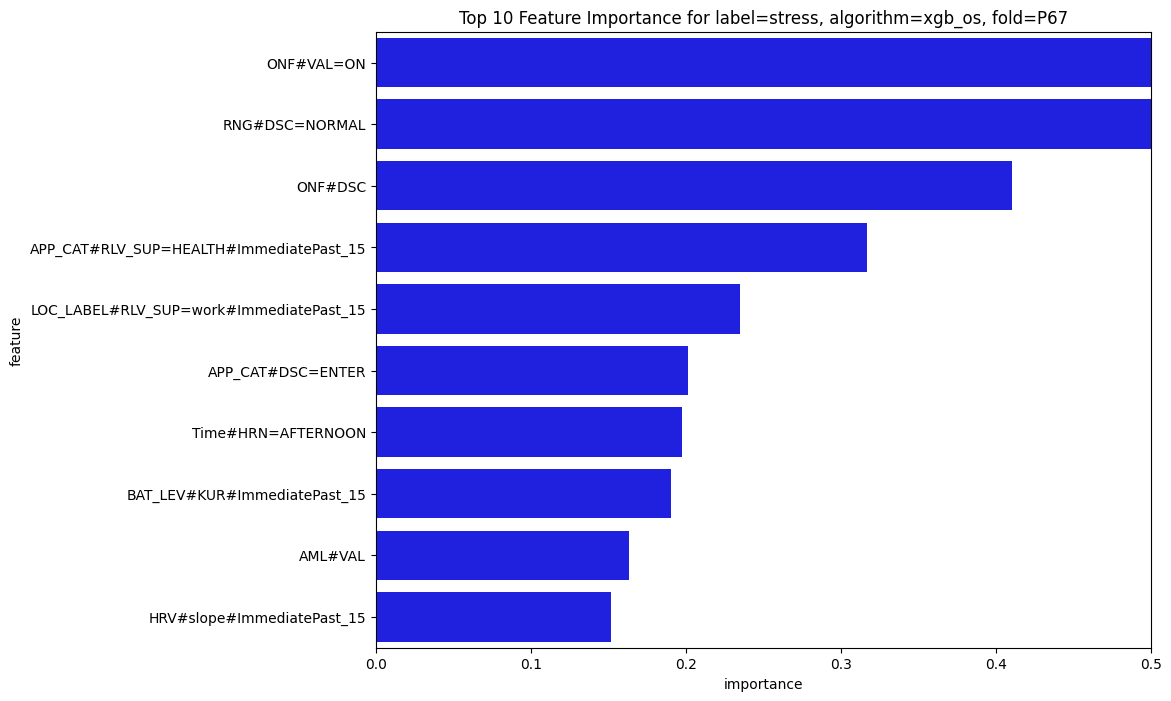

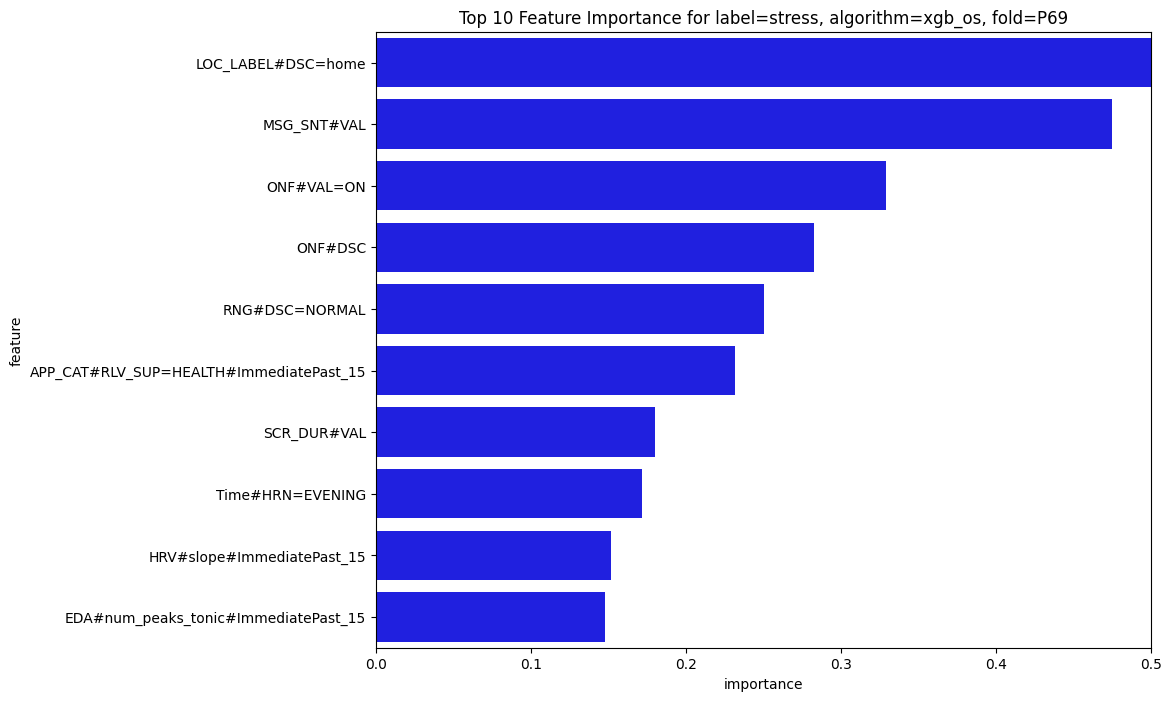

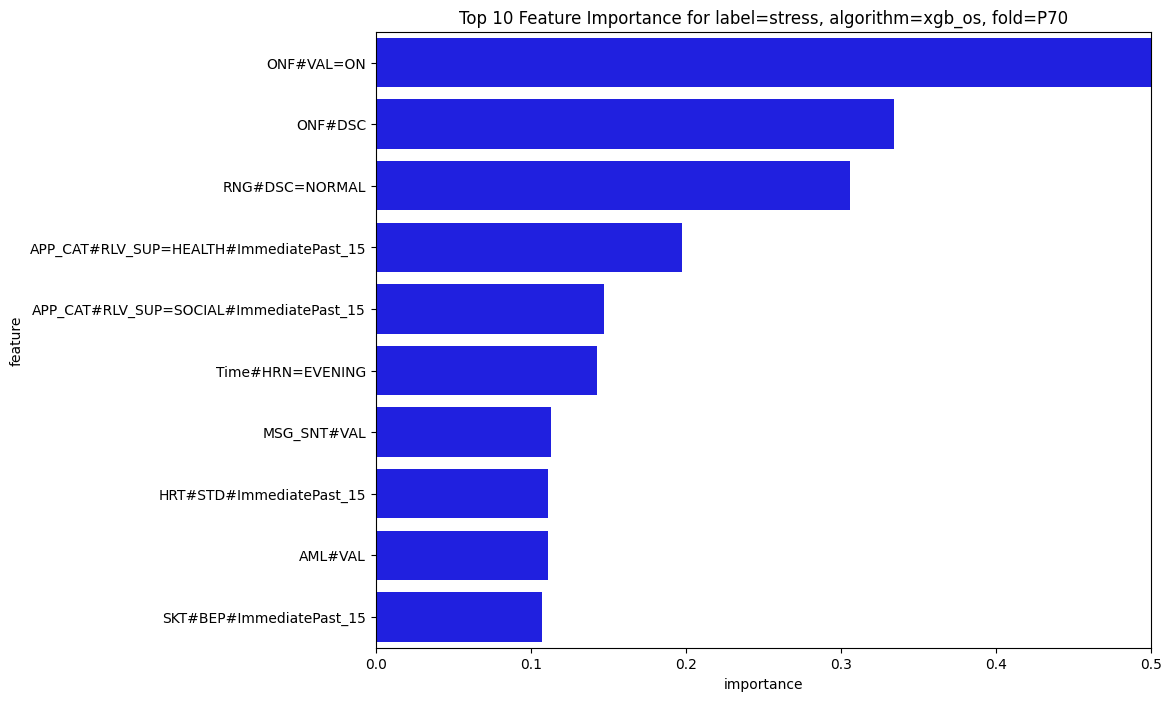

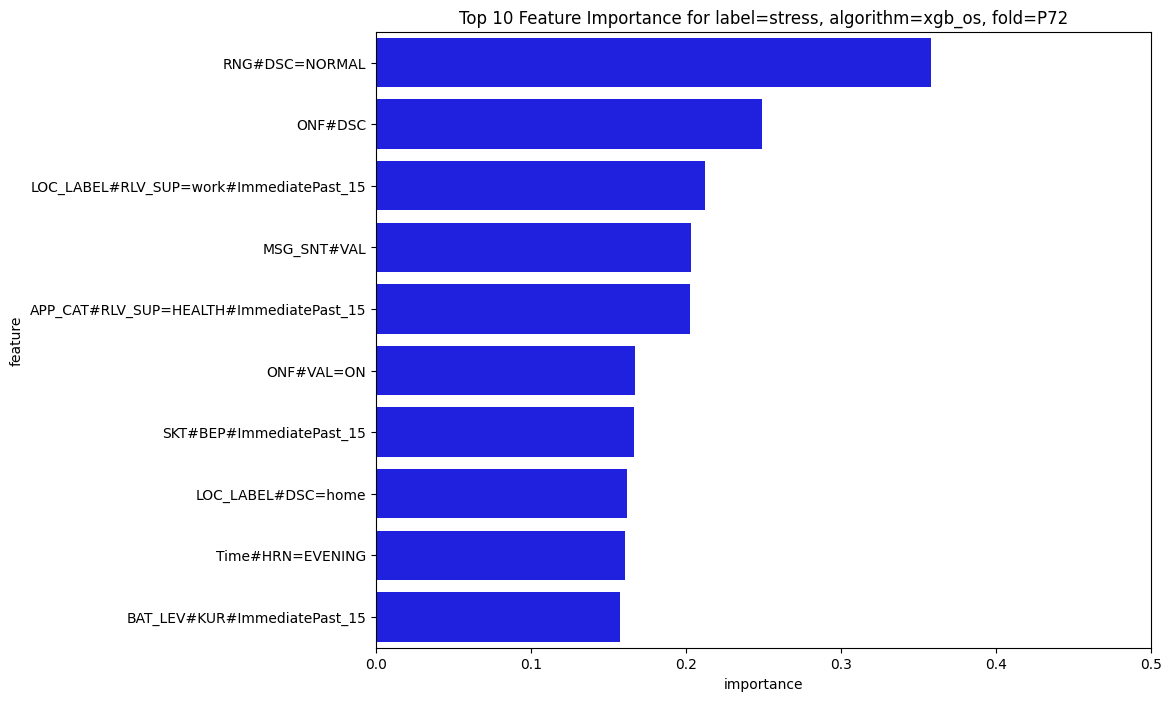

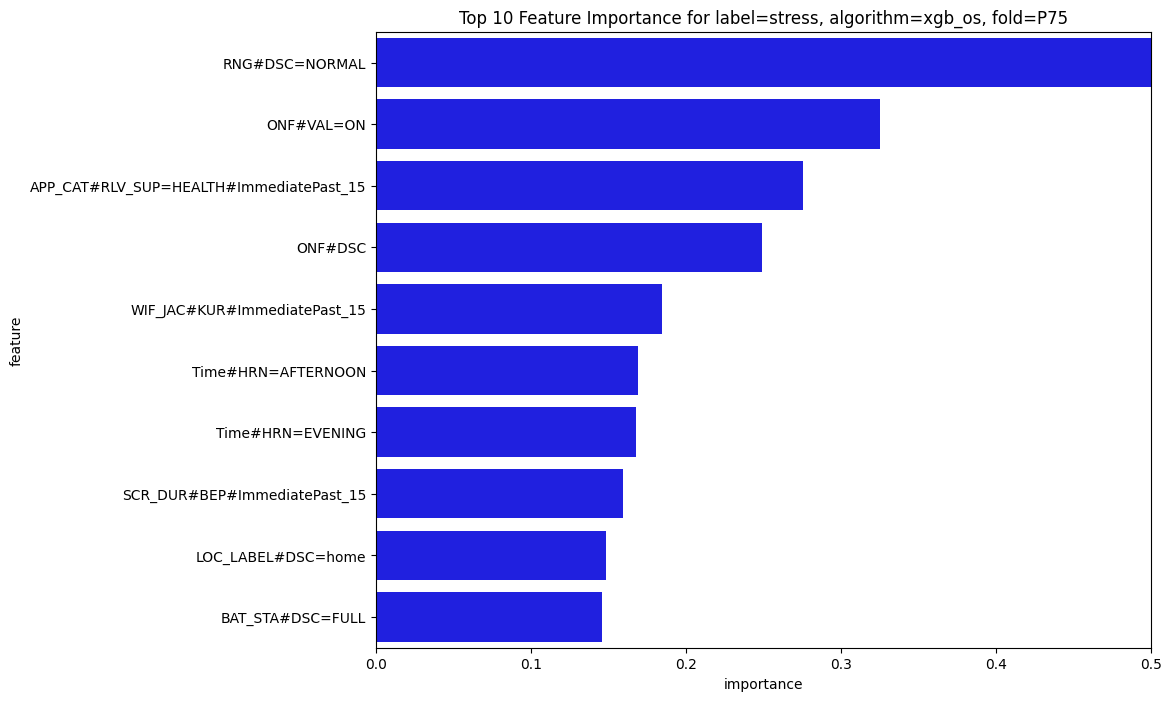

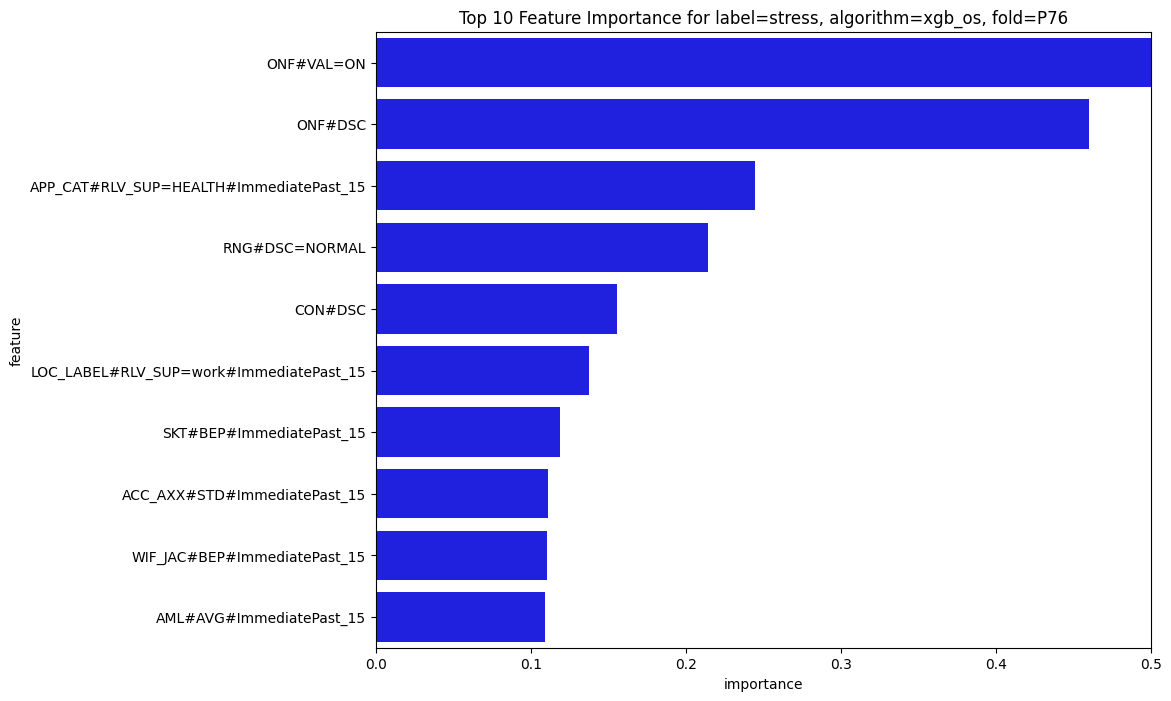

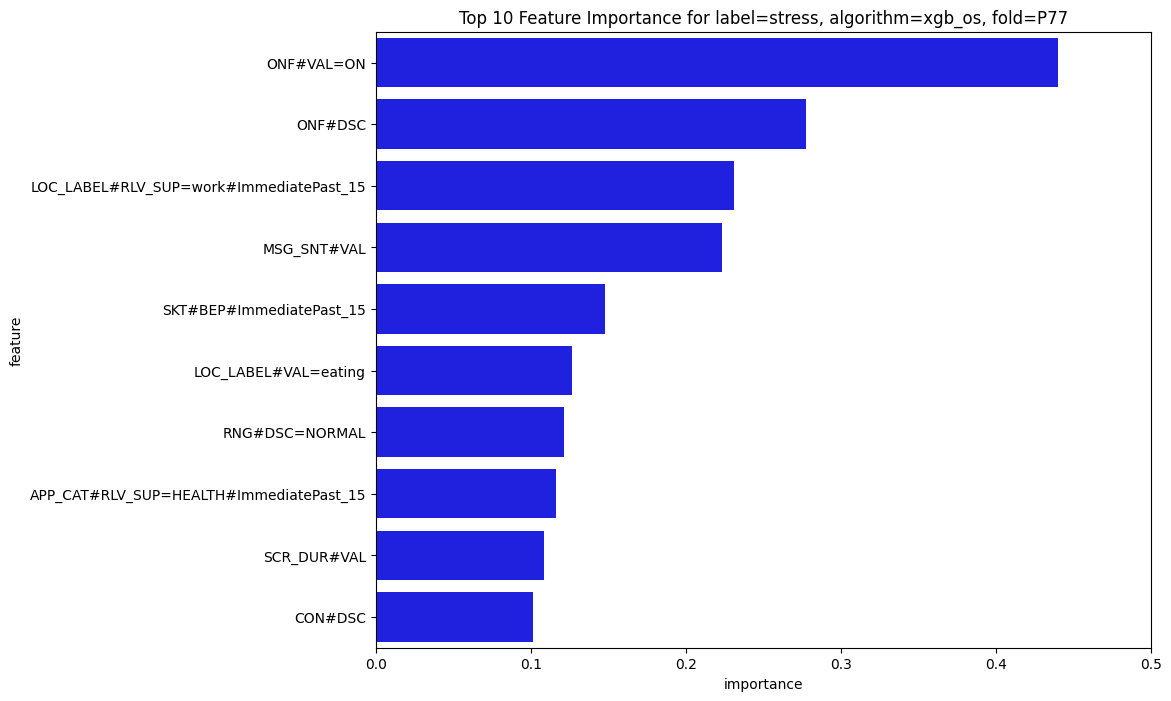

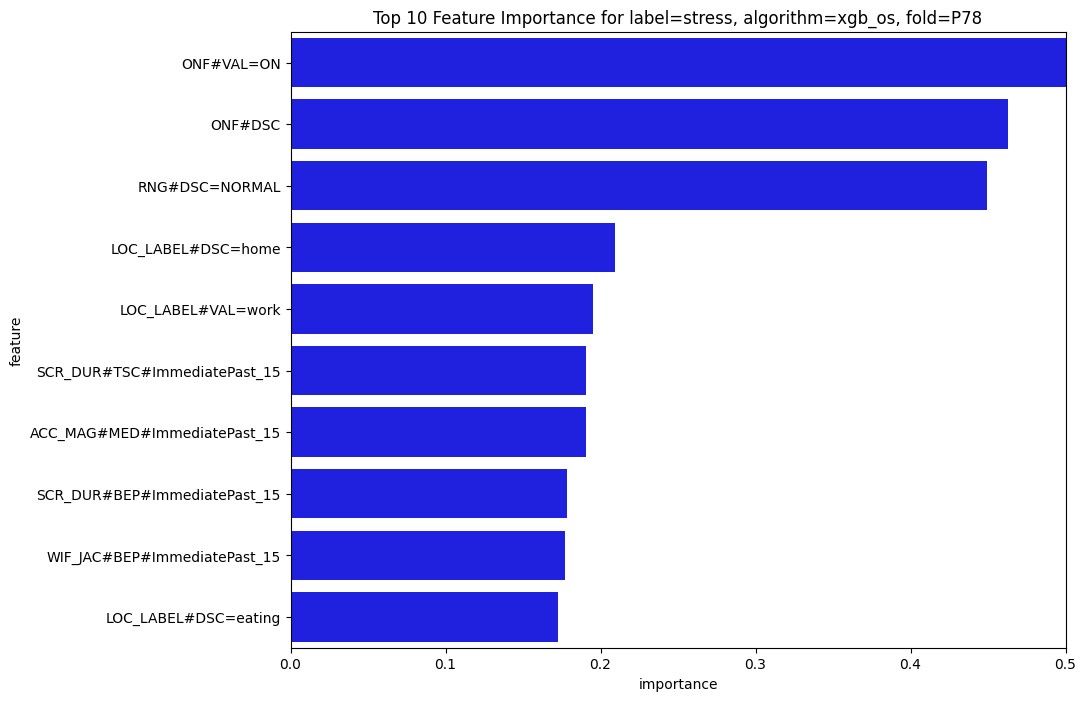

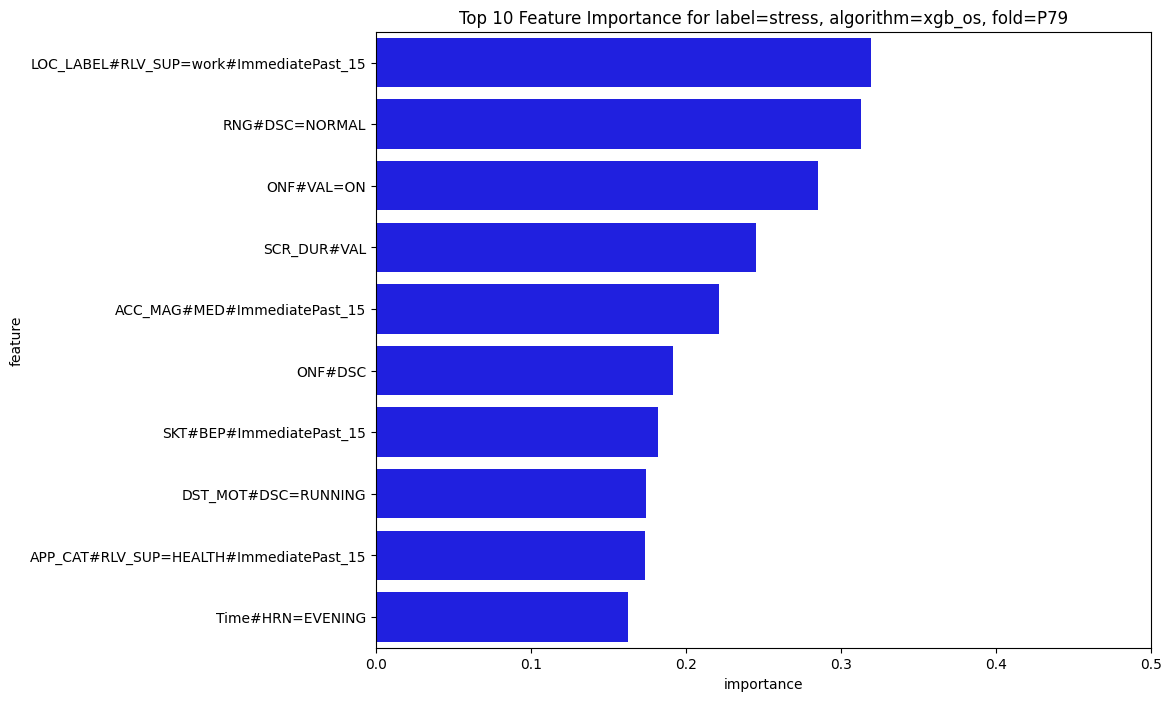

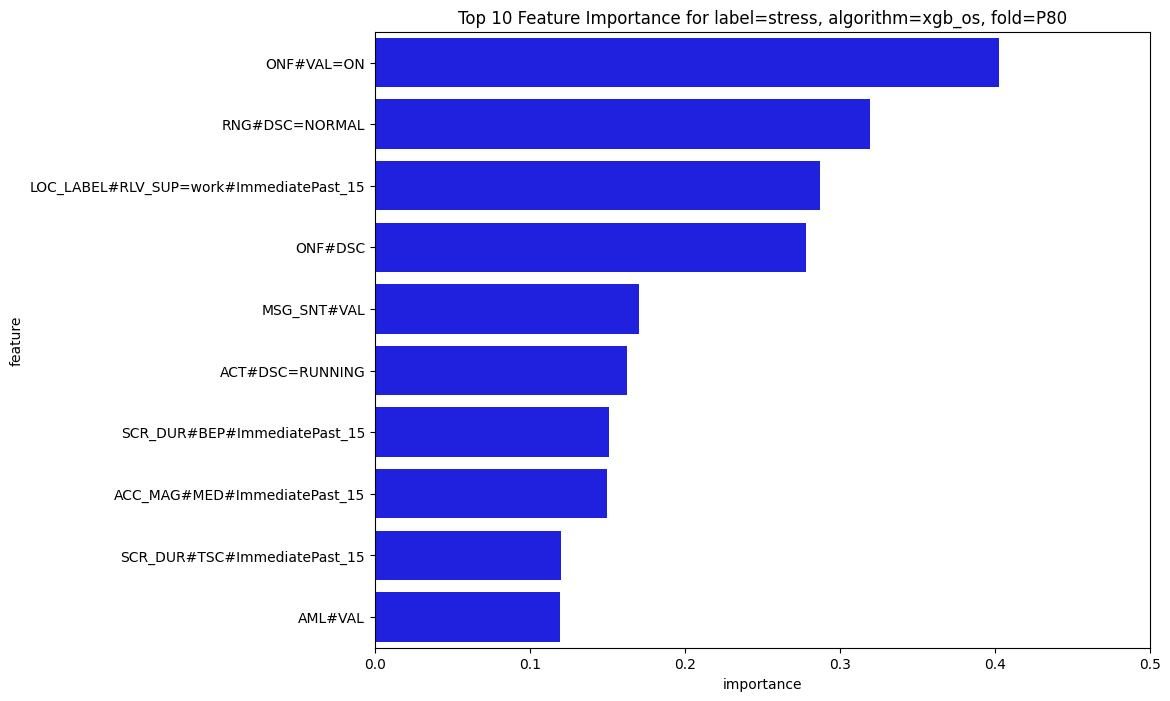

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a plot for each label, algorithm, and fold
for (l, alg, fold), df in IMPORTANCE_SUMMARY_xgb_os.groupby(['label', 'alg', 'fold']):
    # Get top 10 features
    df_top10 = df.dropna().sort_values(by='importance', ascending=False).head(10)
    plt.figure(figsize=(10,8))
    sns.barplot(data=df_top10, x='importance', y='feature', color='b')
    plt.title(f'Top 10 Feature Importance for label={l}, algorithm={alg}, fold={fold}')
    plt.xlim([0, 0.5])
    plt.show()

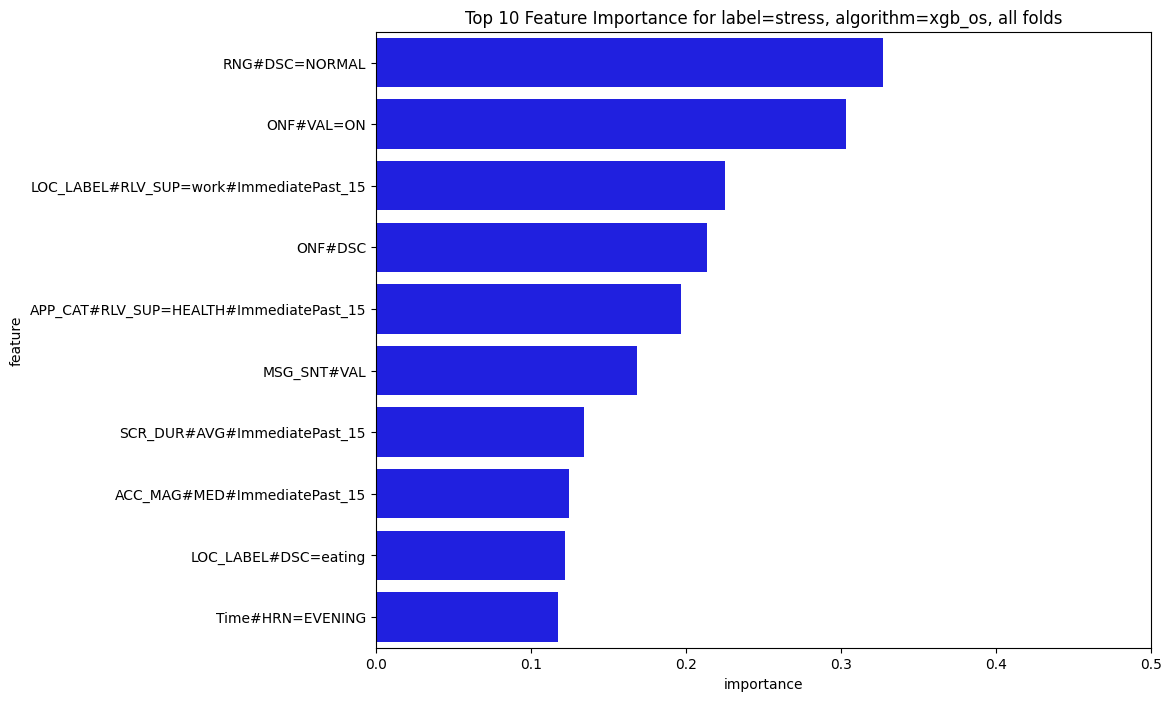

In [16]:
# Create a plot for each label and algorithm, aggregating all folds
for (l, alg), df in IMPORTANCE_SUMMARY_xgb_os.groupby(['label', 'alg']):
    # Aggregate the importance scores across folds and get top 10 features
    df_agg = df.groupby('feature')['importance'].mean().reset_index()
    df_agg_top10 = df_agg.sort_values(by='importance', ascending=False).head(10)

    plt.figure(figsize=(10,8))
    sns.barplot(data=df_agg_top10, x='importance', y='feature', color='b')
    plt.title(f'Top 10 Feature Importance for label={l}, algorithm={alg}, all folds')
    plt.xlim([0, 0.5])

    plt.show()

# Comparing High Performance Group and Low Performance Group

We already visualize individual feature importance and confusion matrix, but it is difficult to get meaningful insights from individual anlysis.
- As fo sensor (loso evaluation),
what is high performance and low performance (loso)?
    - We define high performance group as top 4 AUC-ROC
    - We define low performance group as worst 4 AUC-ROC

In [36]:
#Define what is high performance group and low performance group.
uid_low_performance =  RESULTS_xgbos[['split', 'test_roauc']].sort_values('test_roauc',ascending = True)[:4].split.values.tolist()
uid_high_performance = RESULTS_xgbos[['split', 'test_roauc']].sort_values('test_roauc',ascending = False)[:4].split.values.tolist()

In [37]:
IMPORTANCE_SUMMARY_xgb_os_high_performance = IMPORTANCE_SUMMARY_xgb_os.loc[IMPORTANCE_SUMMARY_xgb_os['fold'].isin(uid_high_performance)]
IMPORTANCE_SUMMARY_xgb_os_low_performance = IMPORTANCE_SUMMARY_xgb_os.loc[IMPORTANCE_SUMMARY_xgb_os['fold'].isin(uid_low_performance)]

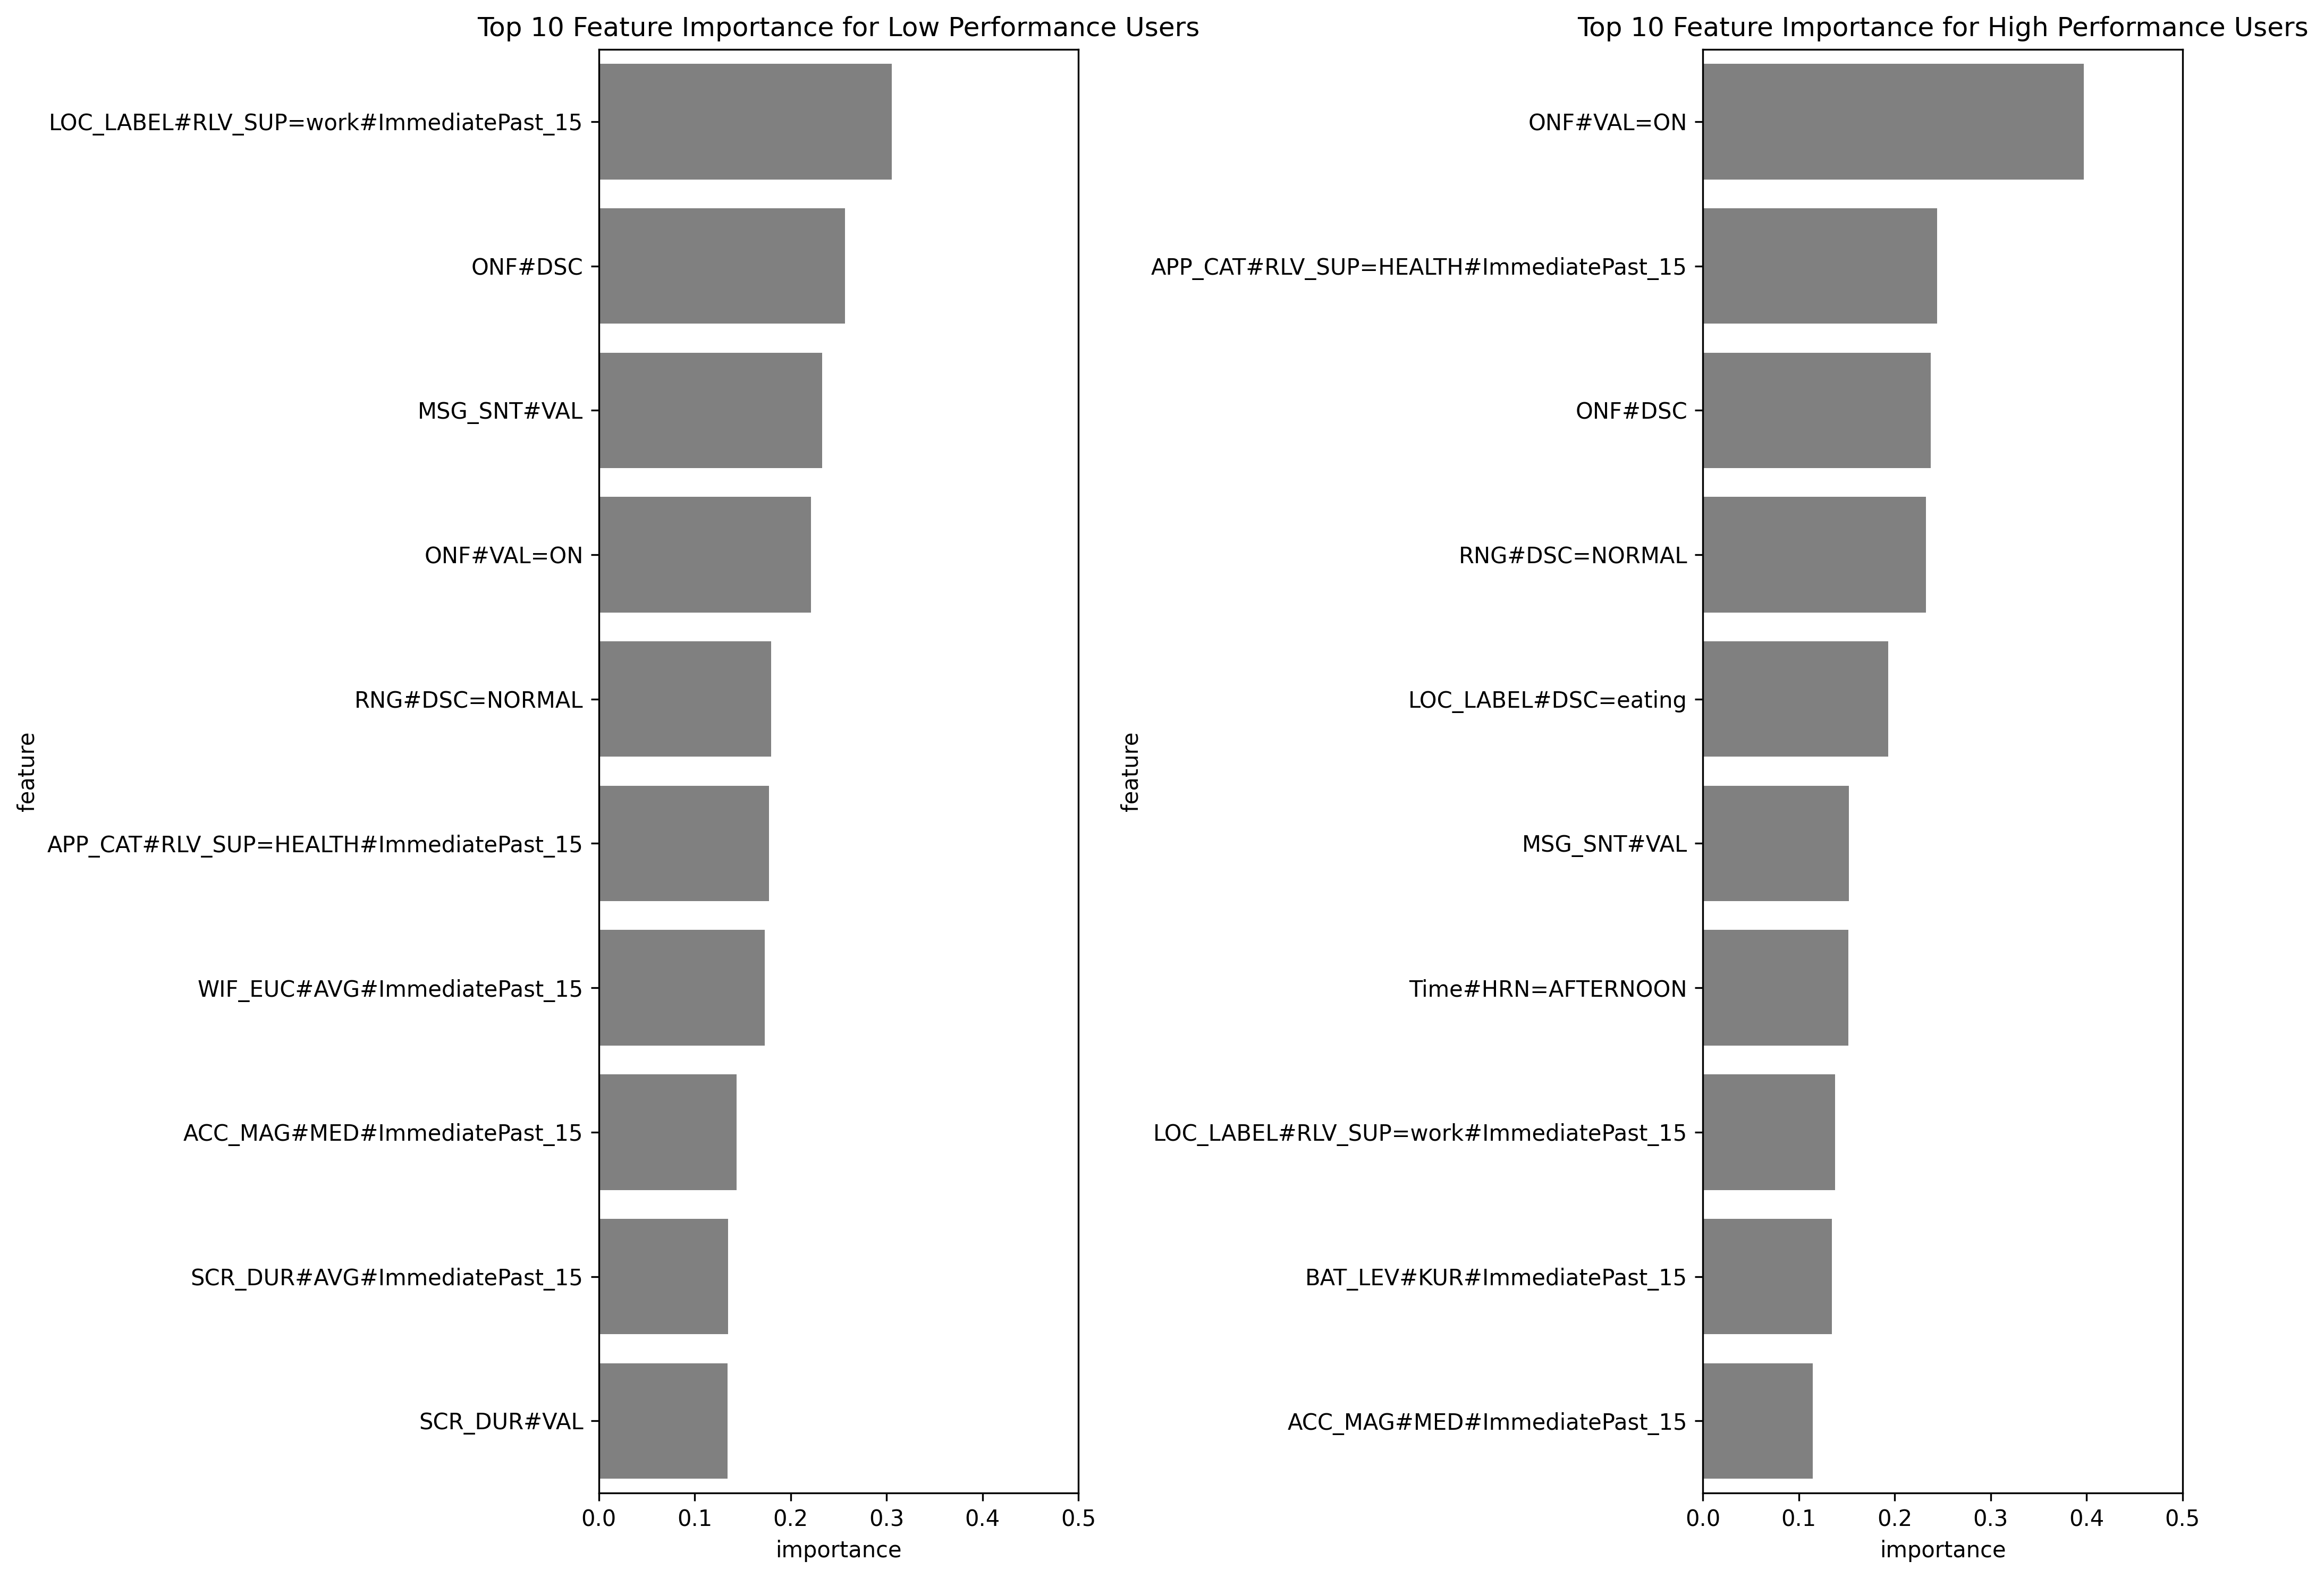

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the figure size and DPI for clear and large enough figures
fig, axs = plt.subplots(1, 2, figsize=(14, 10), dpi=300)  # Wider plots to accommodate long feature names

for i, (data, title) in enumerate([
    (IMPORTANCE_SUMMARY_xgb_os_low_performance, 'Low Performance Users'),
    (IMPORTANCE_SUMMARY_xgb_os_high_performance, 'High Performance Users')
]):
    # Group data by label and algorithm
    for (label, alg), df in data.groupby(['label', 'alg']):
        # Aggregate the importance scores across folds and get top 10 features
        df_agg = df.groupby('feature')['importance'].mean().reset_index()
        df_agg_top10 = df_agg.sort_values(by='importance', ascending=False).head(10)

        # Plot top 10 features
        sns.barplot(data=df_agg_top10, x='importance', y='feature', ax=axs[i], color='gray')
        axs[i].set_title(f'Top 10 Feature Importance for {title}')
        axs[i].set_xlim([0, 0.5])  # Adjust the x-axis limit to better fit the data range

plt.tight_layout()
plt.show()


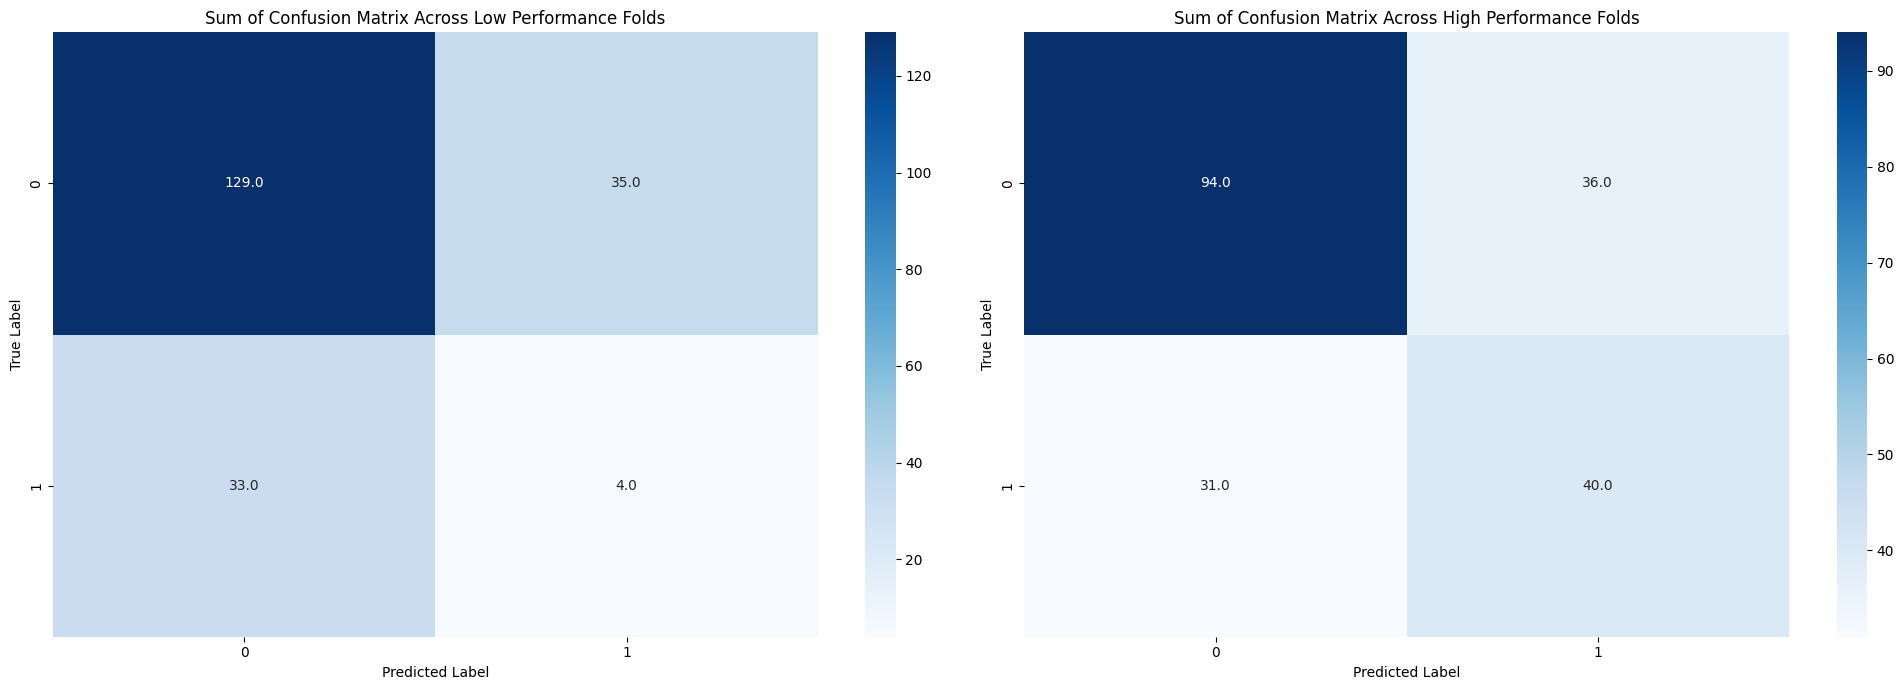

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Load the dataset for low performance users
df_confusion_matrix_low = RESULTS_xgbos[RESULTS_xgbos['split'].isin(uid_low_performance)][['split', 'test_true_0_pred_0',
       'test_true_0_pred_1', 'test_true_1_pred_0', 'test_true_1_pred_1']].set_index('split')
mean_confusion_matrix_low = df_confusion_matrix_low.sum()
matrix_low = mean_confusion_matrix_low.values.reshape(2, 2)

# Load the dataset for high performance users
df_confusion_matrix_high = RESULTS_xgbos[RESULTS_xgbos['split'].isin(uid_high_performance)][['split', 'test_true_0_pred_0',
       'test_true_0_pred_1', 'test_true_1_pred_0', 'test_true_1_pred_1']].set_index('split')
mean_confusion_matrix_high = df_confusion_matrix_high.sum()
matrix_high = mean_confusion_matrix_high.values.reshape(2, 2)

# Set up the matplotlib figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(20, 7), dpi=100)

# Plot the low performance confusion matrix
sns.heatmap(matrix_low, annot=True, fmt=".1f", cmap='Blues', ax=axs[0])
axs[0].set_title("Sum of Confusion Matrix Across Low Performance Folds")
axs[0].set_xlabel("Predicted Label")
axs[0].set_ylabel("True Label")

# Plot the high performance confusion matrix
sns.heatmap(matrix_high, annot=True, fmt=".1f", cmap='Blues', ax=axs[1])
axs[1].set_title("Sum of Confusion Matrix Across High Performance Folds")
axs[1].set_xlabel("Predicted Label")
axs[1].set_ylabel("True Label")

plt.tight_layout()
plt.show()


# Label Value Time Series Visualization

In [38]:
LABELS_PROC = pd.read_csv(os.path.join(PATH_INTERMEDIATE, 'proc', 'LABELS_PROC.csv'), index_col=['pcode','timestamp'],parse_dates=True)

In [39]:
df = LABELS_PROC[['stress']].reset_index()

In [26]:
import pandas as pd
import plotly.graph_objects as go
import numpy as np


# Create a list of unique users
users = df['pcode'].unique()

# Create an empty list to store traces for each user, mean lines, and zero lines
traces = []

# Create a trace for each user's time series and calculate mean value for each user
for user in users:
    user_data = df[df['pcode'] == user]
    mean_value = user_data['stress'].mean()
    trace = go.Scatter(
        x=user_data['timestamp'],
        y=user_data['stress'],
        name=user,
        mode='markers+text',
        marker=dict(size=8, line=dict(width=1), color='blue'),
        text=user_data['stress'].astype(str),
        textposition='top center',
        textfont=dict(size=12)
    )
    traces.append(trace)
    mean_line = go.Scatter(
        x=user_data['timestamp'],
        y=[mean_value] * len(user_data['timestamp']),
        mode='lines',
        name=f'Mean ({user})'
    )
    traces.append(mean_line)
    zero_line = go.Scatter(
        x=user_data['timestamp'],
        y=[0] * len(user_data['timestamp']),
        mode='lines',
        name=f'Zero ({user})'
    )
    traces.append(zero_line)

# Create the layout for the plot
layout = go.Layout(
    title='Time Series Visualization',
    xaxis=dict(title='Timestamp'),
    yaxis=dict(title='Stress', range=[-4, 4])  # Set the desired range for the y-axis
)

# Create the figure with data and layout
fig = go.Figure(data=traces, layout=layout)

# Create the dropdown menu
buttons = []
for user in users:
    button = dict(
        label=user,
        method='update',
        args=[{'visible': [user in trace.name for trace in traces]}]
    )
    buttons.append(button)

updatemenus = list([
    dict(
        buttons=buttons,
        direction='down',
        active=0,
        showactive=True
    )
])

# Update the figure layout with the dropdown menu
fig.update_layout(updatemenus=updatemenus)

# Show the interactive plot
fig.show()


In [27]:
#The following code is designed for reordering for the sake of time series split
#################################################
df = LABELS_PROC[['stress']].reset_index()
# Normalize the datetime for each user
# df['datetime'] = df.groupby('user_id')['datetime'].transform(lambda x: x - x.min())
df['timestamp'] = df.groupby('pcode')['timestamp'].transform(lambda x: x - x.min().normalize())

# Sort the DataFrame by datetime
df = df.sort_values(by=[ 'timestamp'])
random_timestamp = pd.datetime(year=1970, month=1, day=1, hour=1)
df['timestamp'] = df['timestamp'] + random_timestamp

/tmp/ipykernel_741479/490817896.py:10: FutureWarning:

The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.



In [28]:
import pandas as pd
import plotly.graph_objects as go
import numpy as np

# Create a list of unique users
users = df['pcode'].unique()

# Create an empty list to store traces for each user
traces = []

# Create a trace for each user's time series
for user in users:
    user_data = df[df['pcode'] == user]
    trace = go.Scatter(
        x=user_data['timestamp'],
        y=user_data['stress'],
        name=user,
        mode='markers+text',
        marker=dict(size=8, line=dict(width=1), color='blue'),
        text=user_data['stress'].astype(str),
        textposition='top center',
        textfont=dict(size=12)
    )
    traces.append(trace)

# Calculate the overall mean value for all users
mean_value = np.mean(df['stress'])

# Create traces for the mean value line and the horizontal line at 0 for all users
mean_line = go.Scatter(
    x=df['timestamp'],
    y=[mean_value] * len(df['timestamp']),
    mode='lines',
    name='Mean (All Users)'
)
zero_line = go.Scatter(
    x=df['timestamp'],
    y=[0] * len(df['timestamp']),
    mode='lines',
    name='Zero (All Users)'
)

traces.append(mean_line)
traces.append(zero_line)

# Create the layout for the plot
layout = go.Layout(
    title='Time Series Visualization',
    xaxis=dict(title='Timestamp'),
    yaxis=dict(title='Stress', range=[-4, 4])
)

# Create the figure with data and layout
fig = go.Figure(data=traces, layout=layout)

# Show the interactive plot
fig.show()

In [29]:
#The following code is designed for reordering for the sake of time series split
#################################################
df = LABELS_PROC[['stress']].reset_index()
df = df[df['pcode'].isin(uid_low_performance)]
# Normalize the datetime for each user
# df['datetime'] = df.groupby('user_id')['datetime'].transform(lambda x: x - x.min())
df['timestamp'] = df.groupby('pcode')['timestamp'].transform(lambda x: x - x.min().normalize())

# Sort the DataFrame by datetime
df = df.sort_values(by=[ 'timestamp'])
random_timestamp = pd.datetime(year=1970, month=1, day=1, hour=1)
df['timestamp'] = df['timestamp'] + random_timestamp

/tmp/ipykernel_741479/473884817.py:11: FutureWarning:

The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.



In [30]:
import pandas as pd
import plotly.graph_objects as go
import numpy as np


# Create a list of unique users
users = df['pcode'].unique()

# Create an empty list to store traces for each user, mean lines, and zero lines
traces = []

# Create a trace for each user's time series and calculate mean value for each user
for user in users:
    user_data = df[df['pcode'] == user]
    mean_value = user_data['stress'].mean()
    trace = go.Scatter(
        x=user_data['timestamp'],
        y=user_data['stress'],
        name=user,
        mode='markers+text',
        marker=dict(size=8, line=dict(width=1), color='blue'),
        text=user_data['stress'].astype(str),
        textposition='top center',
        textfont=dict(size=12)
    )
    traces.append(trace)
    mean_line = go.Scatter(
        x=user_data['timestamp'],
        y=[mean_value] * len(user_data['timestamp']),
        mode='lines',
        name=f'Mean ({user})'
    )
    traces.append(mean_line)
    zero_line = go.Scatter(
        x=user_data['timestamp'],
        y=[0] * len(user_data['timestamp']),
        mode='lines',
        name=f'Zero ({user})'
    )
    traces.append(zero_line)

# Create the layout for the plot
layout = go.Layout(
    title='Time Series Visualization',
    xaxis=dict(title='Timestamp'),
    yaxis=dict(title='Stress', range=[-4, 4])  # Set the desired range for the y-axis
)

# Create the figure with data and layout
fig = go.Figure(data=traces, layout=layout)

# Create the dropdown menu
buttons = []
for user in users:
    button = dict(
        label=user,
        method='update',
        args=[{'visible': [user in trace.name for trace in traces]}]
    )
    buttons.append(button)

updatemenus = list([
    dict(
        buttons=buttons,
        direction='down',
        active=0,
        showactive=True
    )
])

# Update the figure layout with the dropdown menu
fig.update_layout(updatemenus=updatemenus)

# Show the interactive plot
fig.show()


In [31]:
import pandas as pd
import plotly.graph_objects as go
import numpy as np

# Create a list of unique users
users = df['pcode'].unique()

# Create an empty list to store traces for each user
traces = []

# Create a trace for each user's time series
for user in users:
    user_data = df[df['pcode'] == user]
    trace = go.Scatter(
        x=user_data['timestamp'],
        y=user_data['stress'],
        name=user,
        mode='markers+text',
        marker=dict(size=8, line=dict(width=1), color='blue'),
        text=user_data['stress'].astype(str),
        textposition='top center',
        textfont=dict(size=12)
    )
    traces.append(trace)

# Calculate the overall mean value for all users
mean_value = np.mean(df['stress'])

# Create traces for the mean value line and the horizontal line at 0 for all users
mean_line = go.Scatter(
    x=df['timestamp'],
    y=[mean_value] * len(df['timestamp']),
    mode='lines',
    name='Mean (All Users)'
)
zero_line = go.Scatter(
    x=df['timestamp'],
    y=[0] * len(df['timestamp']),
    mode='lines',
    name='Zero (All Users)'
)

traces.append(mean_line)
traces.append(zero_line)

# Create the layout for the plot
layout = go.Layout(
    
    xaxis=dict(title='Timestamp'),
    yaxis=dict(title='Stress', range=[-4, 4])
)

# Create the figure with data and layout
fig = go.Figure(data=traces, layout=layout)

# Show the interactive plot
fig.show()

In [32]:
#The following code is designed for reordering for the sake of time series split
#################################################
df = LABELS_PROC[['stress']].reset_index()
df = df[df['pcode'].isin(uid_high_performance)]
# Normalize the datetime for each user
# df['datetime'] = df.groupby('user_id')['datetime'].transform(lambda x: x - x.min())
df['timestamp'] = df.groupby('pcode')['timestamp'].transform(lambda x: x - x.min().normalize())

# Sort the DataFrame by datetime
df = df.sort_values(by=[ 'timestamp'])
random_timestamp = pd.datetime(year=1970, month=1, day=1, hour=1)
df['timestamp'] = df['timestamp'] + random_timestamp

/tmp/ipykernel_741479/988886537.py:11: FutureWarning:

The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.



In [33]:
import pandas as pd
import plotly.graph_objects as go
import numpy as np


# Create a list of unique users
users = df['pcode'].unique()

# Create an empty list to store traces for each user, mean lines, and zero lines
traces = []

# Create a trace for each user's time series and calculate mean value for each user
for user in users:
    user_data = df[df['pcode'] == user]
    mean_value = user_data['stress'].mean()
    trace = go.Scatter(
        x=user_data['timestamp'],
        y=user_data['stress'],
        name=user,
        mode='markers+text',
        marker=dict(size=8, line=dict(width=1), color='blue'),
        text=user_data['stress'].astype(str),
        textposition='top center',
        textfont=dict(size=12)
    )
    traces.append(trace)
    mean_line = go.Scatter(
        x=user_data['timestamp'],
        y=[mean_value] * len(user_data['timestamp']),
        mode='lines',
        name=f'Mean ({user})'
    )
    traces.append(mean_line)
    zero_line = go.Scatter(
        x=user_data['timestamp'],
        y=[0] * len(user_data['timestamp']),
        mode='lines',
        name=f'Zero ({user})'
    )
    traces.append(zero_line)

# Create the layout for the plot
layout = go.Layout(
    title='Time Series Visualization',
    xaxis=dict(title='Timestamp'),
    yaxis=dict(title='Stress', range=[-4, 4])  # Set the desired range for the y-axis
)

# Create the figure with data and layout
fig = go.Figure(data=traces, layout=layout)

# Create the dropdown menu
buttons = []
for user in users:
    button = dict(
        label=user,
        method='update',
        args=[{'visible': [user in trace.name for trace in traces]}]
    )
    buttons.append(button)

updatemenus = list([
    dict(
        buttons=buttons,
        direction='down',
        active=0,
        showactive=True
    )
])

# Update the figure layout with the dropdown menu
fig.update_layout(updatemenus=updatemenus)

# Show the interactive plot
fig.show()


In [34]:
import pandas as pd
import plotly.graph_objects as go
import numpy as np

# Create a list of unique users
users = df['pcode'].unique()

# Create an empty list to store traces for each user
traces = []

# Create a trace for each user's time series
for user in users:
    user_data = df[df['pcode'] == user]
    trace = go.Scatter(
        x=user_data['timestamp'],
        y=user_data['stress'],
        name=user,
        mode='markers+text',
        marker=dict(size=8, line=dict(width=1), color='blue'),
        text=user_data['stress'].astype(str),
        textposition='top center',
        textfont=dict(size=12)
    )
    traces.append(trace)

# Calculate the overall mean value for all users
mean_value = np.mean(df['stress'])

# Create traces for the mean value line and the horizontal line at 0 for all users
mean_line = go.Scatter(
    x=df['timestamp'],
    y=[mean_value] * len(df['timestamp']),
    mode='lines',
    name='Mean (All Users)'
)
zero_line = go.Scatter(
    x=df['timestamp'],
    y=[0] * len(df['timestamp']),
    mode='lines',
    name='Zero (All Users)'
)

traces.append(mean_line)
traces.append(zero_line)

# Create the layout for the plot
layout = go.Layout(
    title='Label Time Series Visualization For High Performance Users',
    xaxis=dict(title='Timestamp'),
    yaxis=dict(title='Stress', range=[-4, 4])
)

# Create the figure with data and layout
fig = go.Figure(data=traces, layout=layout)

# Show the interactive plot
fig.show()

The following is for visualizing label distribution

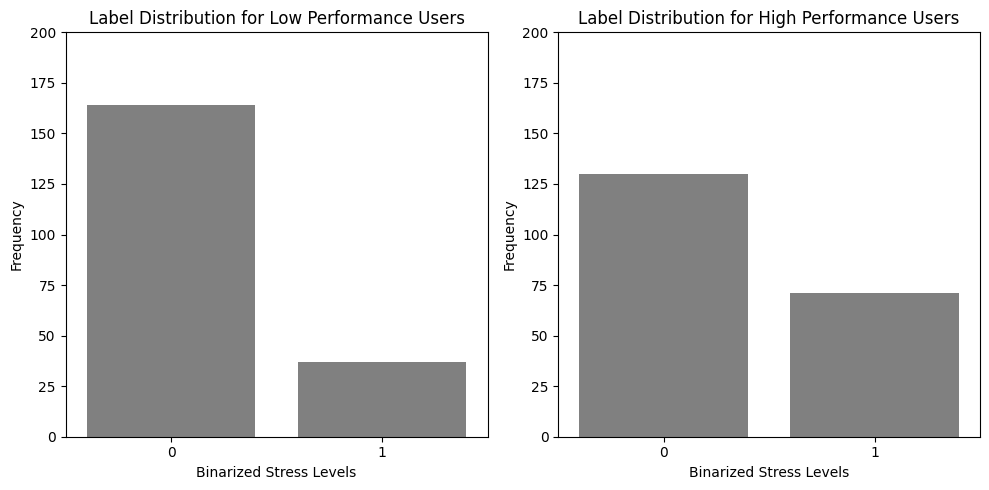

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Sample data preparation
# Assuming 'df' has columns 'pcode' for user IDs and 'stress' for labels



# Binarize labels
df['stress_bin'] = (df['stress'] > 0).astype(int)

# Filter data for low and high performance users
df_low = df[df['pcode'].isin(uid_low_performance)]
df_high = df[df['pcode'].isin(uid_high_performance)]

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot for low performance users
sns.countplot(x='stress_bin', data=df_low, ax=axs[0], color='gray')
axs[0].set_title('Label Distribution for Low Performance Users')
axs[0].set_xlabel('Binarized Stress Levels')
axs[0].set_ylabel('Frequency')
axs[0].set_ylim(0, 200)  # Set y-axis range to 200

# Plot for high performance users
sns.countplot(x='stress_bin', data=df_high, ax=axs[1], color='gray')
axs[1].set_title('Label Distribution for High Performance Users')
axs[1].set_xlabel('Binarized Stress Levels')
axs[1].set_ylabel('Frequency')
axs[1].set_ylim(0, 200)  # Set y-axis range to 200

plt.tight_layout()
plt.show()
